# HR-аналитика компании "Работа с заботой"

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Поставлены две задачи: 

1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Предсказание уровня удовлетворённости сотрудника

### Загрузка библиотек и написание собственных функций

In [1]:
!pip install phik -q
!pip install -U scikit-learn -q
!pip install shap -q

In [2]:
# импортирую необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats as st 
from scipy.stats import binom, norm
import numpy as np
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer 

from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer



from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

import shap

pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings('ignore')

In [3]:
#функция для исследовательского анализа количественных данных
def analisys_num(data):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    plt.subplot(1,2,1)
    plt.hist(data, bins=20)
    plt.title('Гистограмма показателя')
    plt.xlabel('Значения показателя')
    plt.axvline(data.median(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(data.mean(), color='r', linestyle='-', linewidth=2)
    plt.legend(['Медиана', 'Среднее'], prop={'size': 12})
    plt.subplot(1,2,2)
    plt.title('Боксплот показателя')
    plt.boxplot(data)
    plt.show()
    print('Показатели описательной статистики')
    print(data.describe())

In [4]:
#функция для исследовательского анализа качевтенных данных и построение круговой диаграммы
def analisys_cat_pie(data):
    data.value_counts().plot(kind='pie', autopct='%.2f%%', figsize=(10, 10))
    plt.title('Круговая диаграмма показателя', size=15)
    plt.show()

In [5]:
#функция для исследовательского анализа качевтенных данных и построение столбчатой диаграммы
def analisys_cat_plot(data):
    data.value_counts(ascending=True).plot(kind='bar', alpha=0.8)
    plt.title('Столбчатая диаграмма', size=15)
    plt.xlabel('Количество', size=12)
    plt.ylabel('Значения', size=12)
    plt.show()

### Загрузка и первичный обзор данных 

In [6]:
try:
    train_job_satisfaction_rate = pd.read_csv('C:/Users/Zenbook/Desktop/Проекты/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('C:/Users/Zenbook/Desktop/Проекты/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('C:/Users/Zenbook/Desktop/Проекты/test_target_job_satisfaction_rate.csv')
except:
    print('Произошла ошибка')

In [7]:
train_job_satisfaction_rate.head(10)

id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   
5  405448          hr  middle      low                 7              no   
6  857135       sales  sinior   medium                 9              no   
7  400657  purchasing  middle     high                 9              no   
8  198846          hr  junior      low                 1              no   
9  149797  technology  middle     high                 6              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20  
5                   no                      4   30000                   0.78  
6                   no                      3   56400                   0.56  
7                   no                      3   52800                   0.44  
8                   no                      2   13200                   0.14  
9                   no                      3   54000                   0.47

In [8]:
test_features.head(10)

id        dept   level workload  employment_years last_year_promo  \
0  485046   marketing  junior   medium                 2              no   
1  686555          hr  junior   medium                 1              no   
2  467458       sales  middle      low                 5              no   
3  418655       sales  middle      low                 6              no   
4  789145          hr  middle   medium                 5              no   
5  429973  purchasing  middle   medium                 6              no   
6  850699  technology  junior   medium                 3              no   
7  500791       sales  middle     high                 9              no   
8  767867   marketing  middle     high                 3              no   
9  937235       sales  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800  
5                   no                      3   42000  
6                   no                      3   26400  
7                   no                      4   49200  
8                  yes                      4   62400  
9                  yes                      3   26400

In [9]:
test_target_job_satisfaction_rate.head(10)

id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08
5  817219                   0.76
6  269033                   0.64
7  962356                   0.38
8  649052                   0.14
9  532834                   0.59

### Предобработка данных 

#### Предобработка данных в датафрейме train_job_satisfaction_rate

In [10]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [11]:
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Есть пропуски, заполним их в пайплайне

In [12]:
train_job_satisfaction_rate.duplicated().sum()

0

In [13]:
column_train = ['id', 'dept', 'level',
              'workload', 'last_year_promo',
              'last_year_violations',]
for i in column_train:
    print(f'Уникальные значения показателя {i}')
    print(train_job_satisfaction_rate[i].unique())
    print (train_job_satisfaction_rate[i].nunique())
    print('-'*100)

Уникальные значения показателя id
[155278 653870 184592 ... 533318 706868 338347]
4000
----------------------------------------------------------------------------------------------------
Уникальные значения показателя dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
5
----------------------------------------------------------------------------------------------------
Уникальные значения показателя level
['junior' 'middle' 'sinior' nan]
3
----------------------------------------------------------------------------------------------------
Уникальные значения показателя workload
['medium' 'high' 'low']
3
----------------------------------------------------------------------------------------------------
Уникальные значения показателя last_year_promo
['no' 'yes']
2
----------------------------------------------------------------------------------------------------
Уникальные значения показателя last_year_violations
['no' 'yes']
2
----------------------------------------------

Датафрейм сожержит 4000 строк и 4000 уникальных id, а так же в категориальных данных нет опечаток, то можно сделат ьвывод что скрытых дубликатов в данных нет. При подготовке данных для обучения модели возможно понадобится перевести id в индекс.

#### Предобработка данных в датафрейме test_features

In [14]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [15]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

В датафрейме есть пропуски, но мы их заполним при предподготовке данных.

In [16]:
test_features.duplicated().sum()

0

In [17]:
column_test = ['id', 'dept', 'level',
              'workload', 'last_year_promo',
              'last_year_violations',]
for i in column_test:
    print(f'Уникальные значения показателя {i}')
    print(test_features[i].unique())
    print (test_features[i].nunique())
    print('-'*100)

Уникальные значения показателя id
[485046 686555 467458 ... 305653 160233 771859]
2000
----------------------------------------------------------------------------------------------------
Уникальные значения показателя dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
6
----------------------------------------------------------------------------------------------------
Уникальные значения показателя level
['junior' 'middle' 'sinior' nan]
3
----------------------------------------------------------------------------------------------------
Уникальные значения показателя workload
['medium' 'low' 'high' ' ']
4
----------------------------------------------------------------------------------------------------
Уникальные значения показателя last_year_promo
['no' 'yes']
2
----------------------------------------------------------------------------------------------------
Уникальные значения показателя last_year_violations
['no' 'yes']
2
--------------------------------------

In [18]:
column_test = ['id', 'dept', 'level',
              'workload', 'last_year_promo',
              'last_year_violations',]
for i in column_test:
    print(f'Уникальные значения показателя {i}')
    print(test_features[i].unique())
    print (test_features[i].nunique())
    print('-'*100)

Уникальные значения показателя id
[485046 686555 467458 ... 305653 160233 771859]
2000
----------------------------------------------------------------------------------------------------
Уникальные значения показателя dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
6
----------------------------------------------------------------------------------------------------
Уникальные значения показателя level
['junior' 'middle' 'sinior' nan]
3
----------------------------------------------------------------------------------------------------
Уникальные значения показателя workload
['medium' 'low' 'high' ' ']
4
----------------------------------------------------------------------------------------------------
Уникальные значения показателя last_year_promo
['no' 'yes']
2
----------------------------------------------------------------------------------------------------
Уникальные значения показателя last_year_violations
['no' 'yes']
2
--------------------------------------

#### Предобработка данных в датафрейме test_target_job_satisfaction_rate

In [19]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [20]:
test_target_job_satisfaction_rate.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

In [21]:
test_target_job_satisfaction_rate.duplicated().sum()

0

#### Общие выводы по разделу предподготовка данных

Была проведена предподготовка данных в трех датафреймах. Пропуски типа Nan и пробелы заполним в пайплайне.

### Исследовательский анализ

#### Исследовательский анализ датафрейма train_job_satisfaction_rate

In [22]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


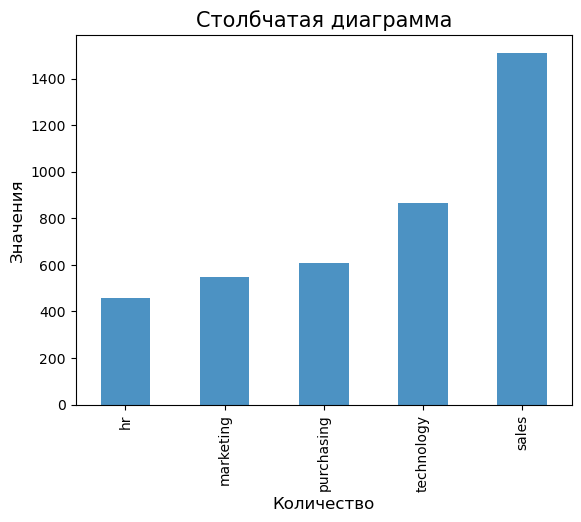

In [23]:
#проведем исследовательский анализ категориальных показателей
analisys_cat_plot(train_job_satisfaction_rate['dept'])

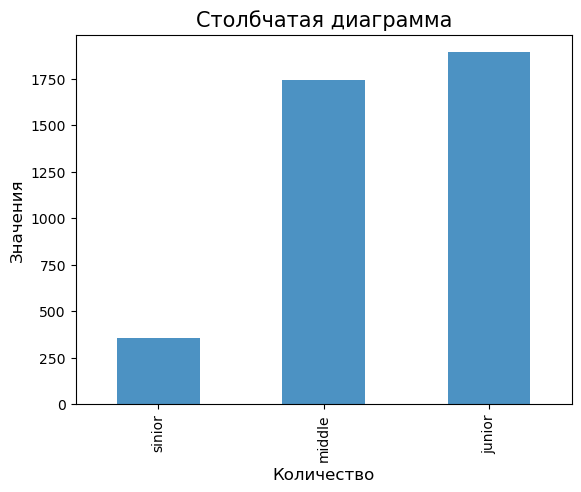

In [24]:
analisys_cat_plot(train_job_satisfaction_rate['level'])

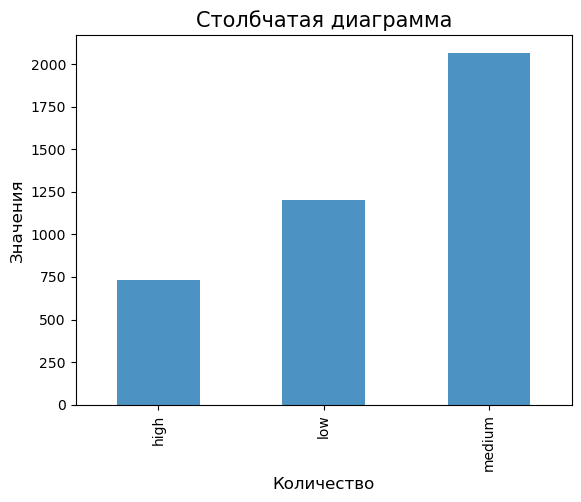

In [25]:
analisys_cat_plot(train_job_satisfaction_rate['workload'])

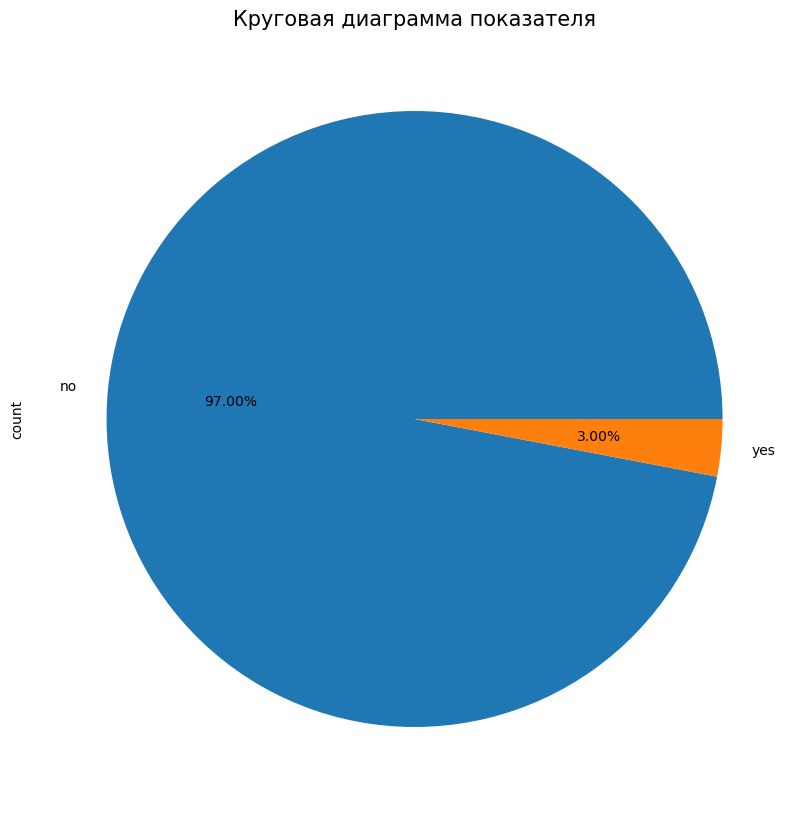

In [26]:
analisys_cat_pie(train_job_satisfaction_rate['last_year_promo'])

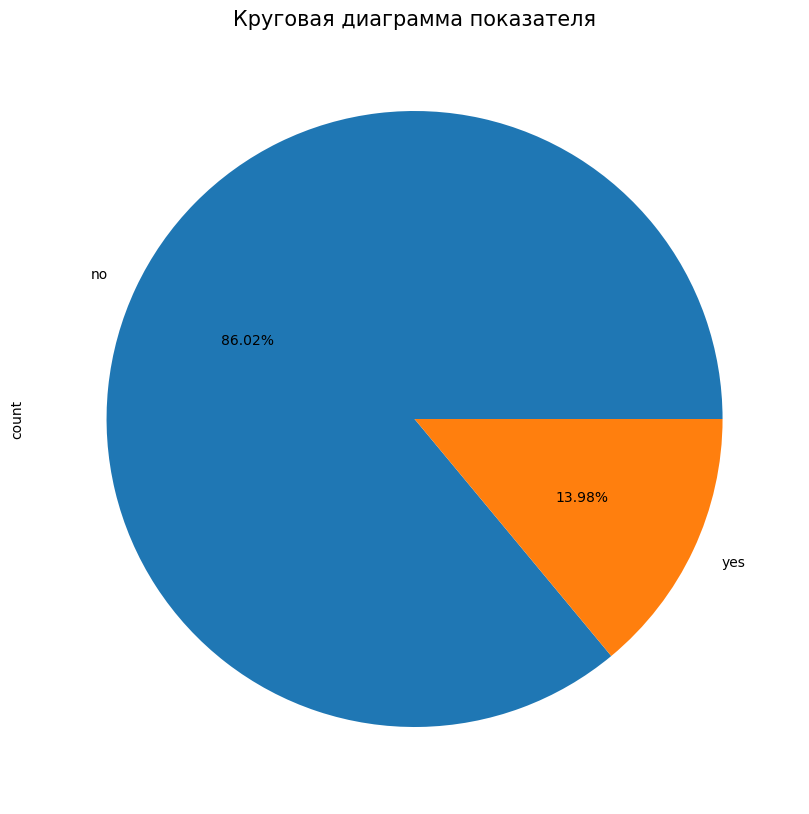

In [27]:
analisys_cat_pie(train_job_satisfaction_rate['last_year_violations'])

Исследование показателя salary


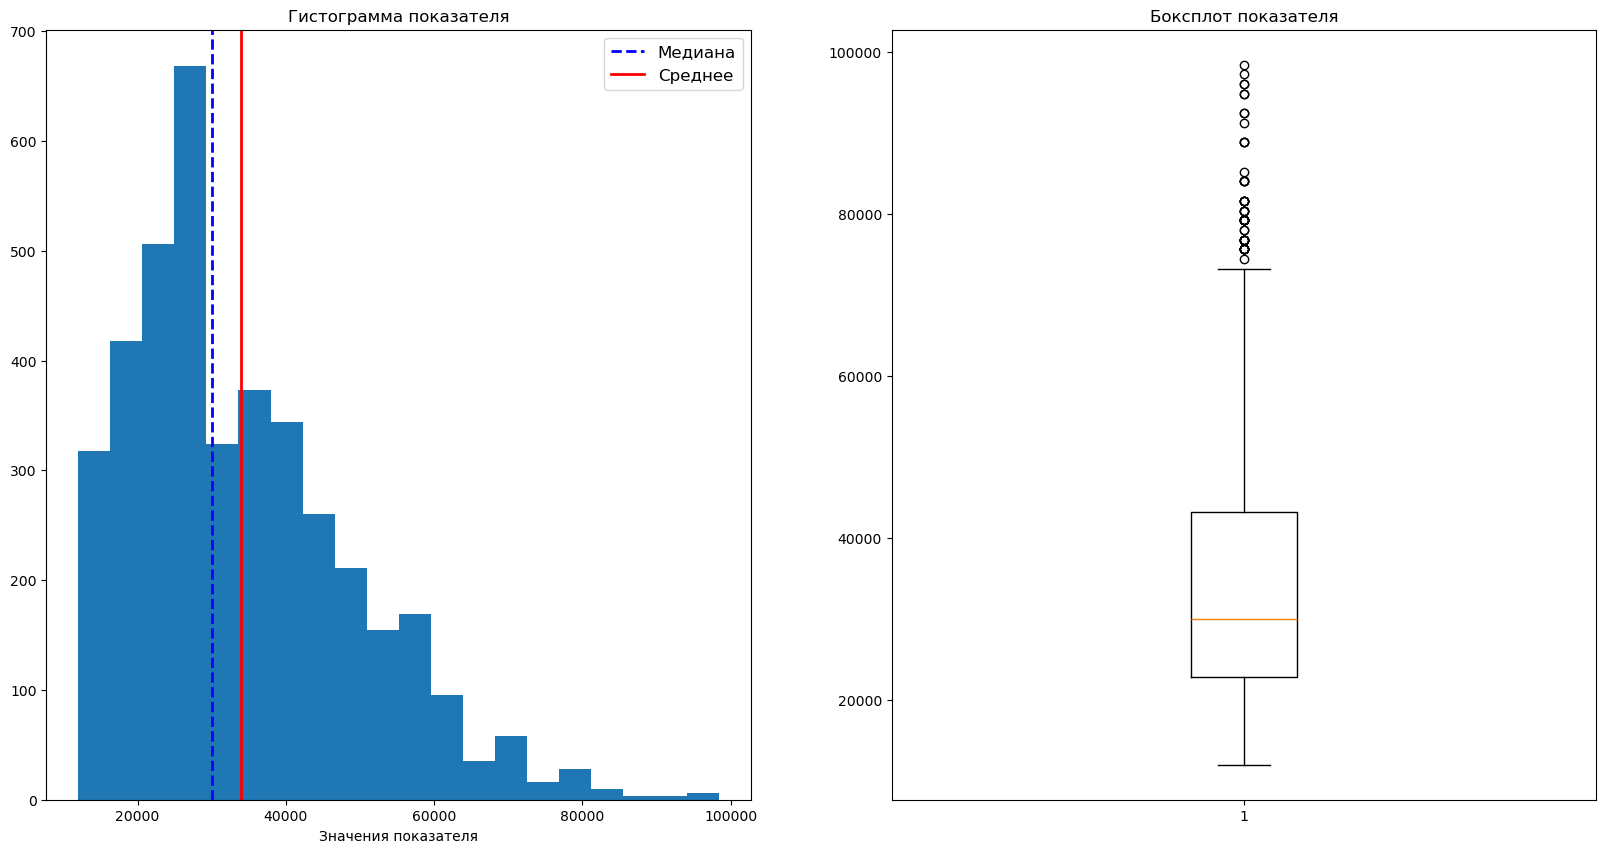

Показатели описательной статистики
count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64
None
----------------------------------------------------------------------------------------------------
Исследование показателя job_satisfaction_rate


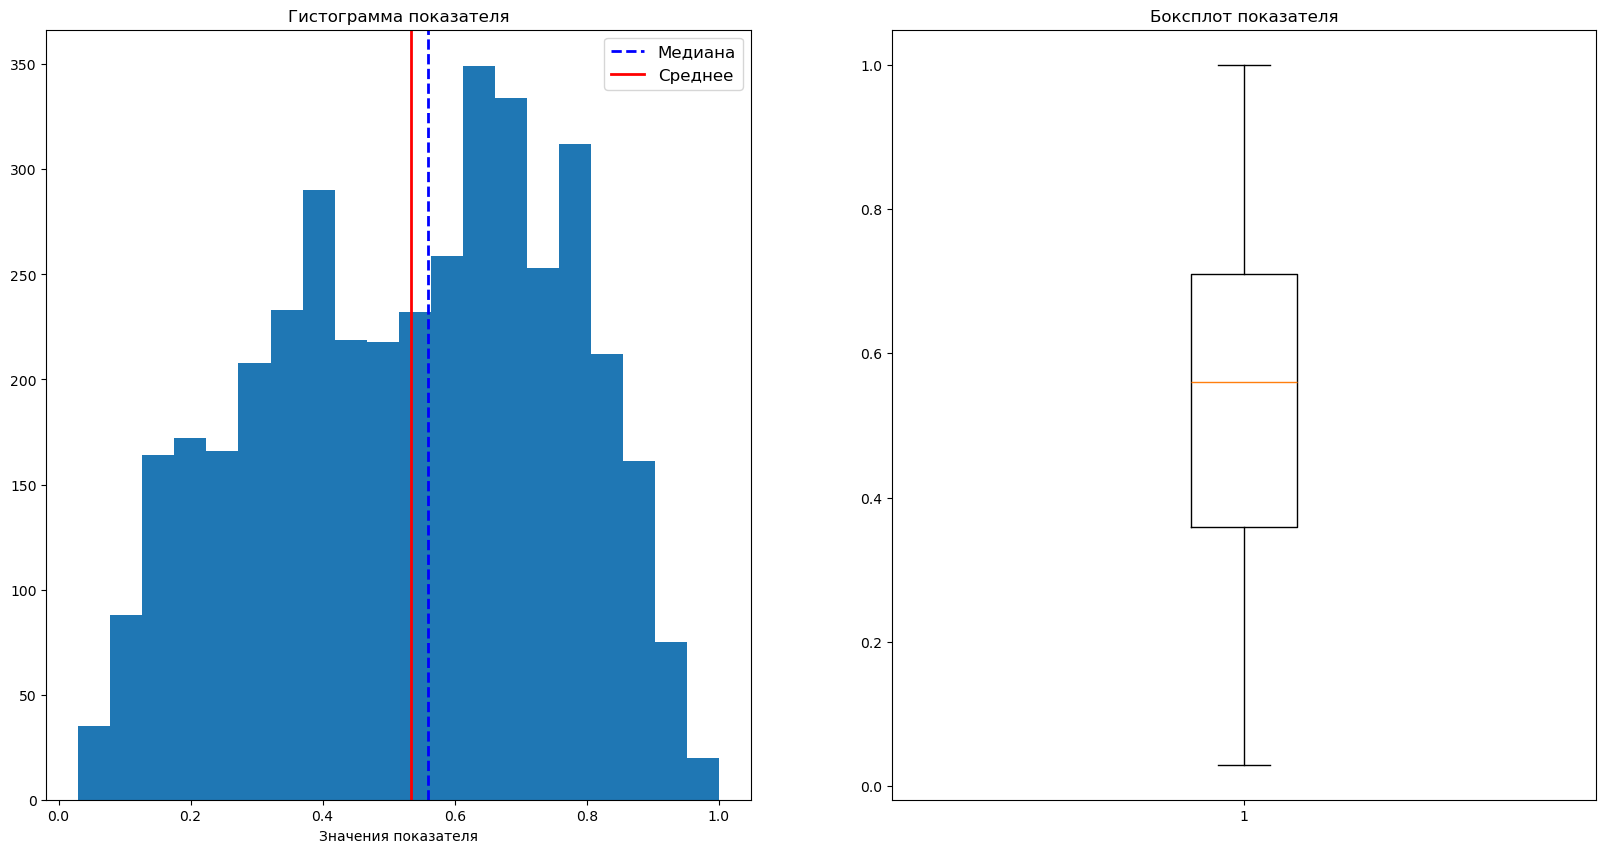

Показатели описательной статистики
count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64
None
----------------------------------------------------------------------------------------------------


In [28]:
#проведем анализ количественных показателей
column_num_train = [#'employment_years', #'supervisor_evaluation',
                   'salary', 'job_satisfaction_rate']

for i in column_num_train:
    print(f'Исследование показателя {i}')
    print (analisys_num(train_job_satisfaction_rate[i]))
    print('-'*100)

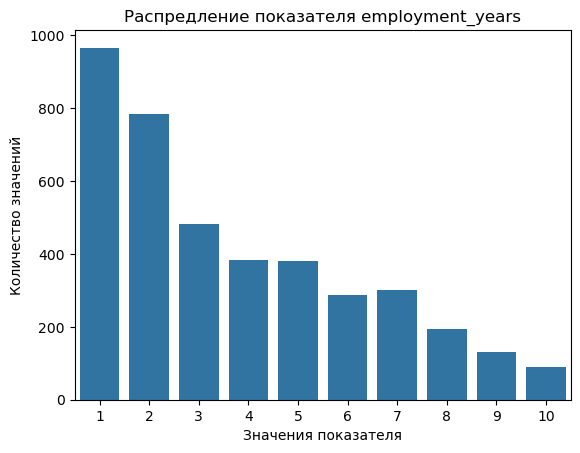

In [29]:
sns.countplot(data = train_job_satisfaction_rate, x ='employment_years')
plt.title('Распредление показателя employment_years')
plt.xlabel('Значения показателя')
plt.ylabel('Количество значений')
plt.show()

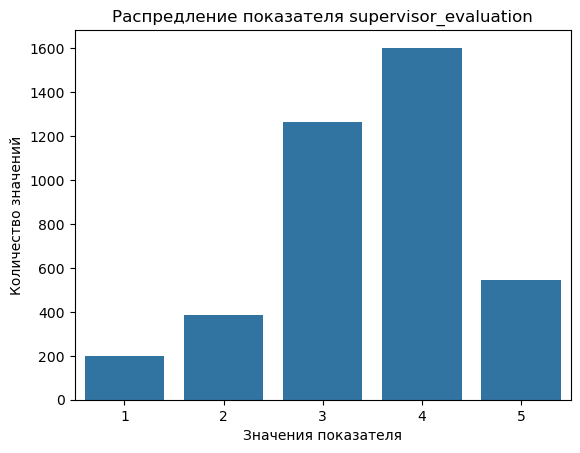

In [30]:
sns.countplot(data = train_job_satisfaction_rate, x = 'supervisor_evaluation')
plt.title('Распредление показателя supervisor_evaluation')
plt.xlabel('Значения показателя')
plt.ylabel('Количество значений')
plt.show()

 </font><b>Выводы исследовательского анализа датафрейма: </b></font><br>
 
 1. Больше всего в датафремйме представлены работники из категрии sales
 
 2. Чаще всего встречаются работники уровня junior
 
 3. В большей степени работники имеют среднюю загруженность
 
 4. В среднем в компании работают 3 года
 
 5. В среднем оценка качества работы оценивается в районе 3.5
 
 6. Средняя зарплата на уровне 30000 
 
 7. Уровень удовлетворенности работника в среднем равен 0.5
 
 8. В течение года сотрудников не повышали.
 
 9. Большая часть сотрудников не нарушала условия трудового договора.
 
 
 Тк далее по плану проекта не предполагается корреляционный анализ, проведен его в этом разделе.

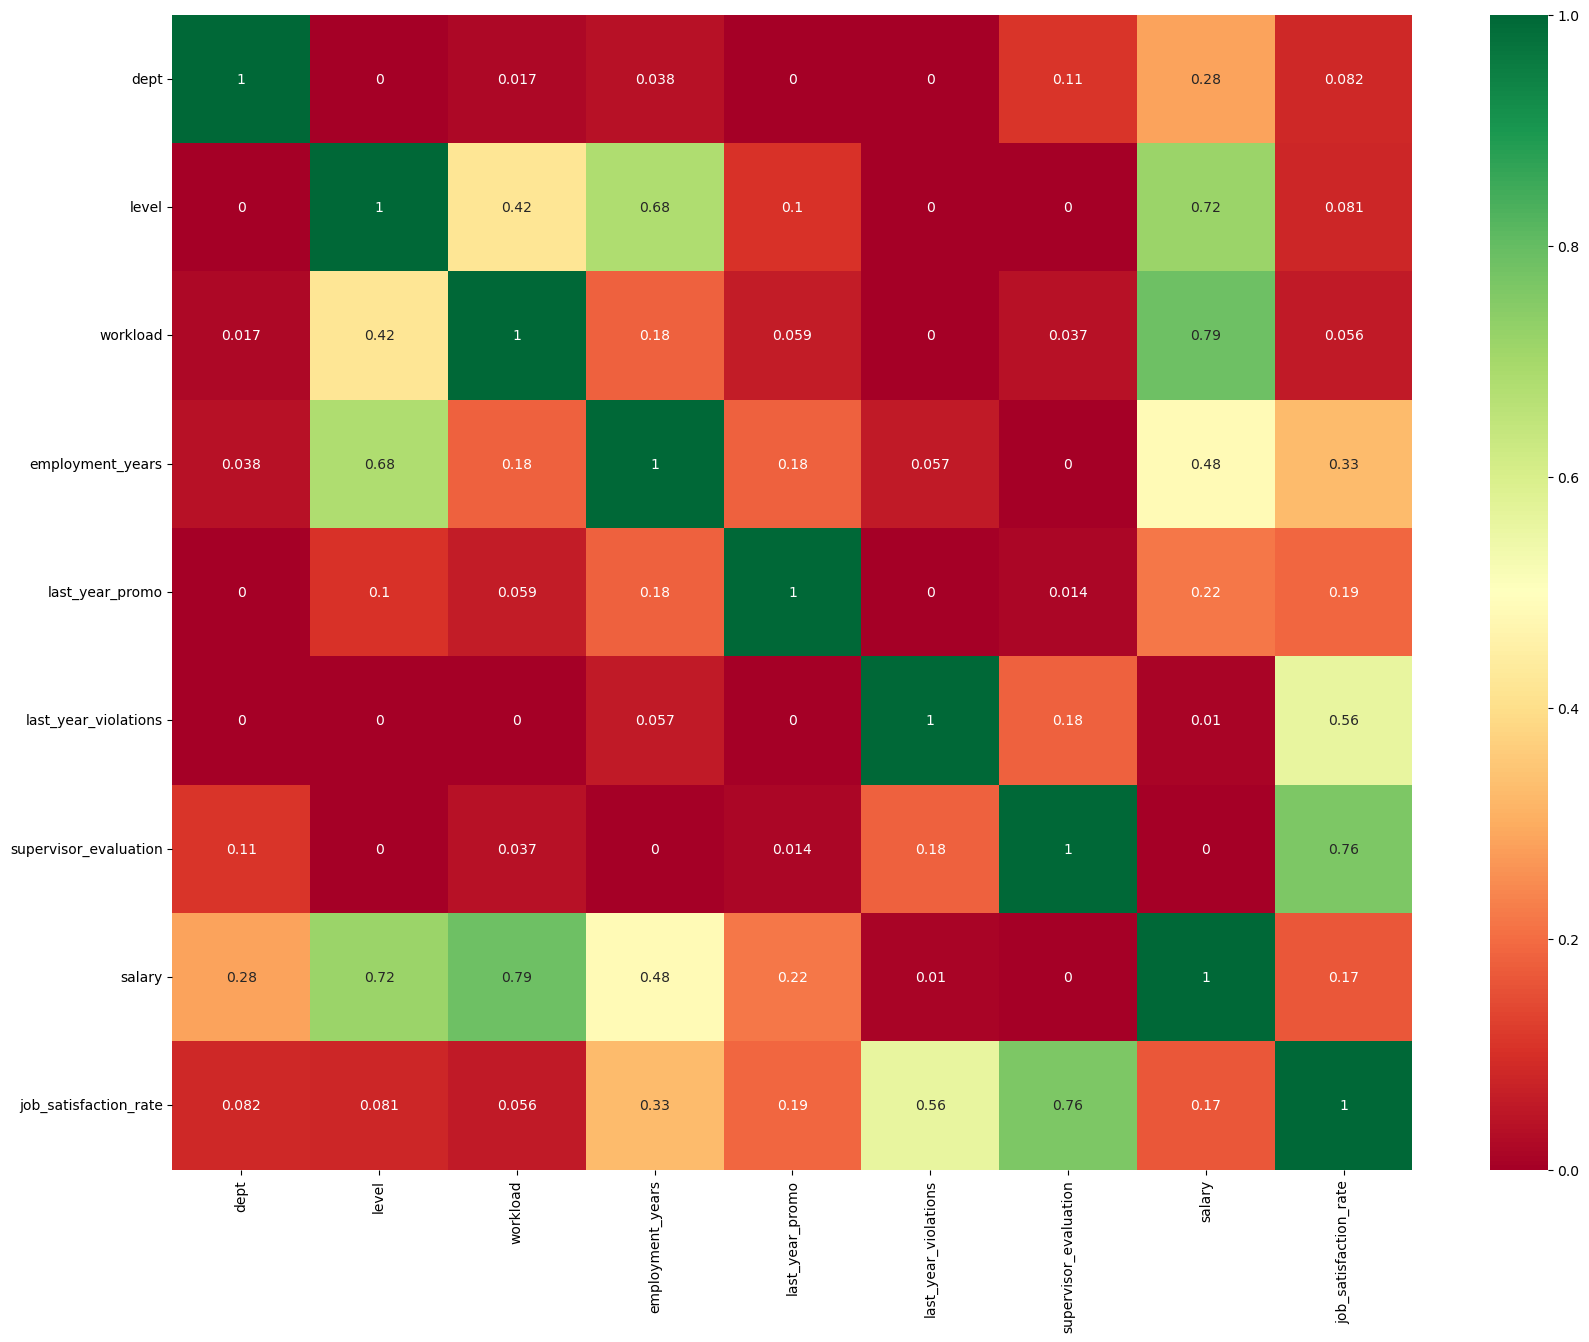

In [31]:
corr_matrix = train_job_satisfaction_rate.drop('id', axis = 1).phik_matrix(interval_cols = column_num_train) 
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn') 
plt.show()

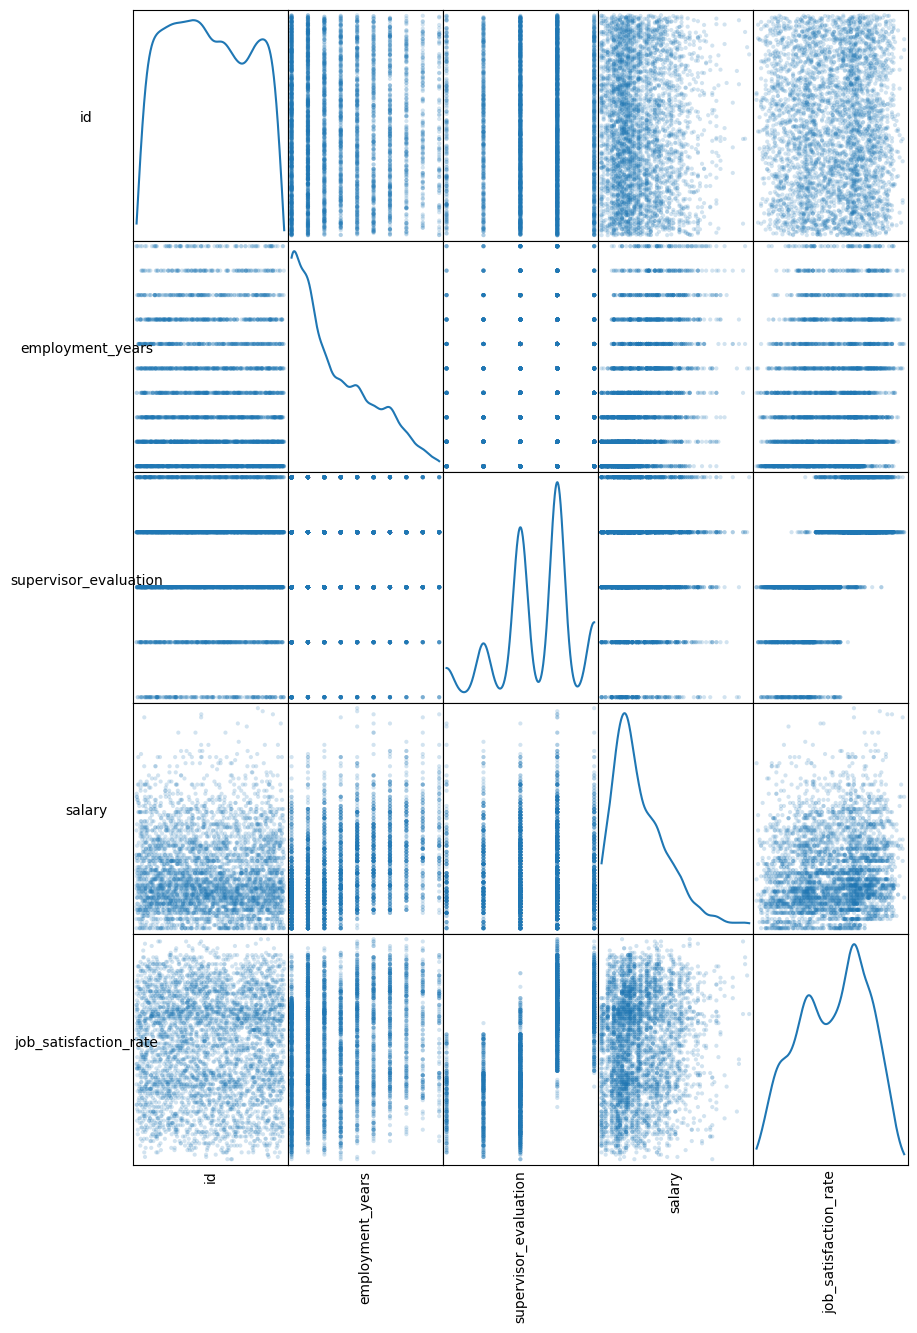

In [32]:
df_scatter = train_job_satisfaction_rate
sm = pd.plotting.scatter_matrix(df_scatter, figsize = (10, 15), alpha=0.2, diagonal='kde')

[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]


[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

Целевой признак больше всего связан с повышением в течение года и оценки качества работы руководителем

#### Исследовательский анализ test_features

In [33]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [34]:
column_for_plot = ['dept', 'level', 'workload']
column_for_pie = ['last_year_promo','last_year_violations']
column_for_hist = ['employment_years', 'supervisor_evaluation', 'salary']

Исследование показателя dept


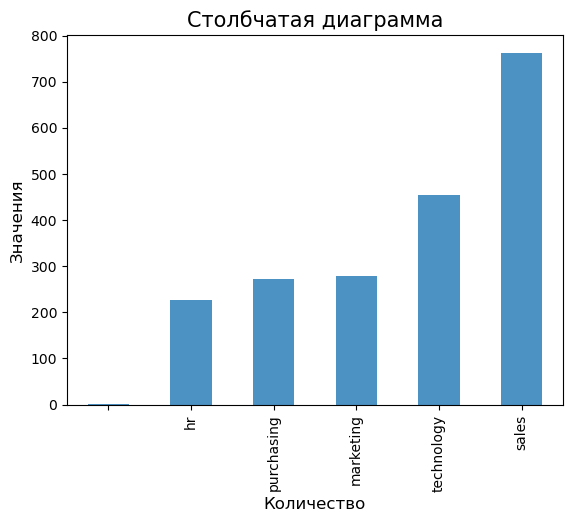

None
----------------------------------------------------------------------------------------------------
Исследование показателя level


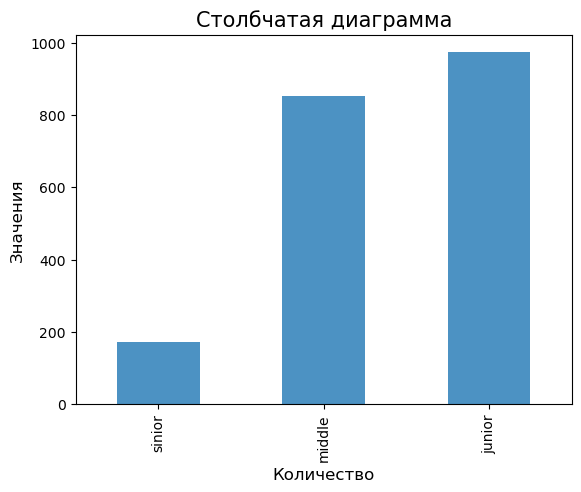

None
----------------------------------------------------------------------------------------------------
Исследование показателя workload


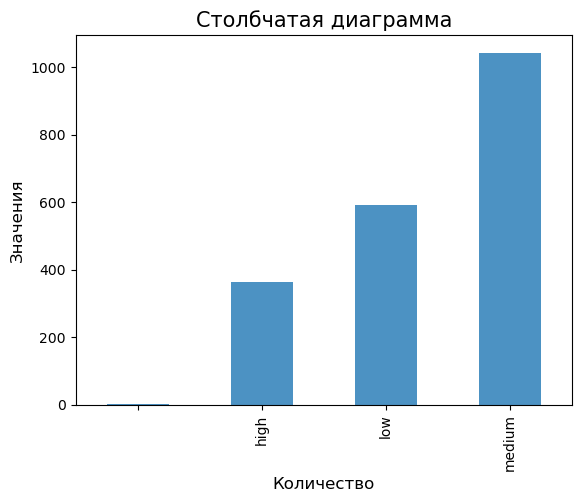

None
----------------------------------------------------------------------------------------------------


In [35]:
for i in column_for_plot:
    print(f'Исследование показателя {i}')
    print (analisys_cat_plot(test_features[i]))
    print('-'*100)

Исследование показателя last_year_promo


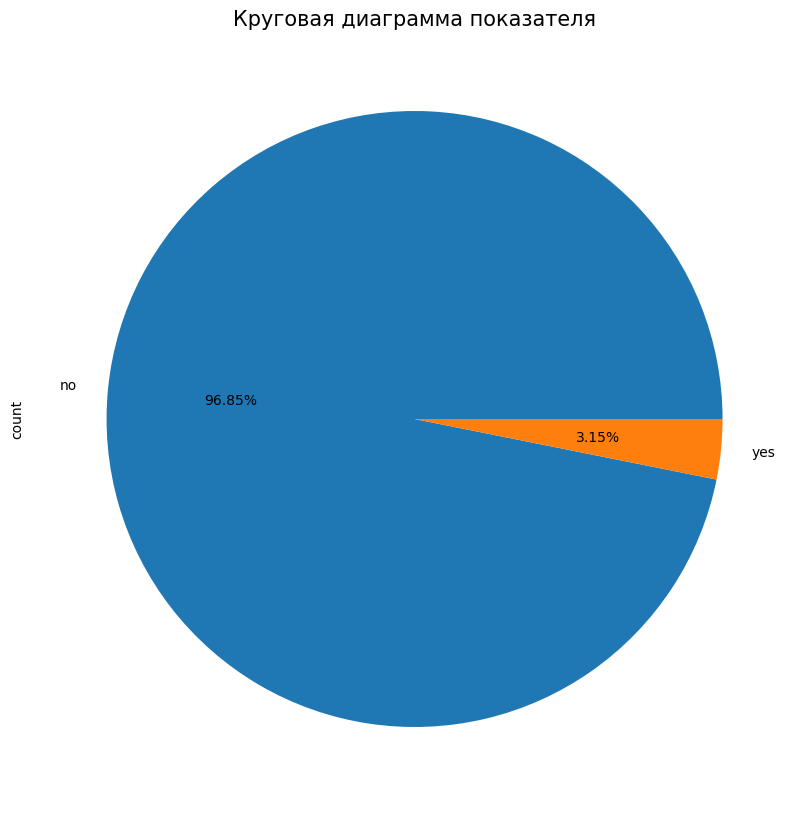

None
----------------------------------------------------------------------------------------------------
Исследование показателя last_year_violations


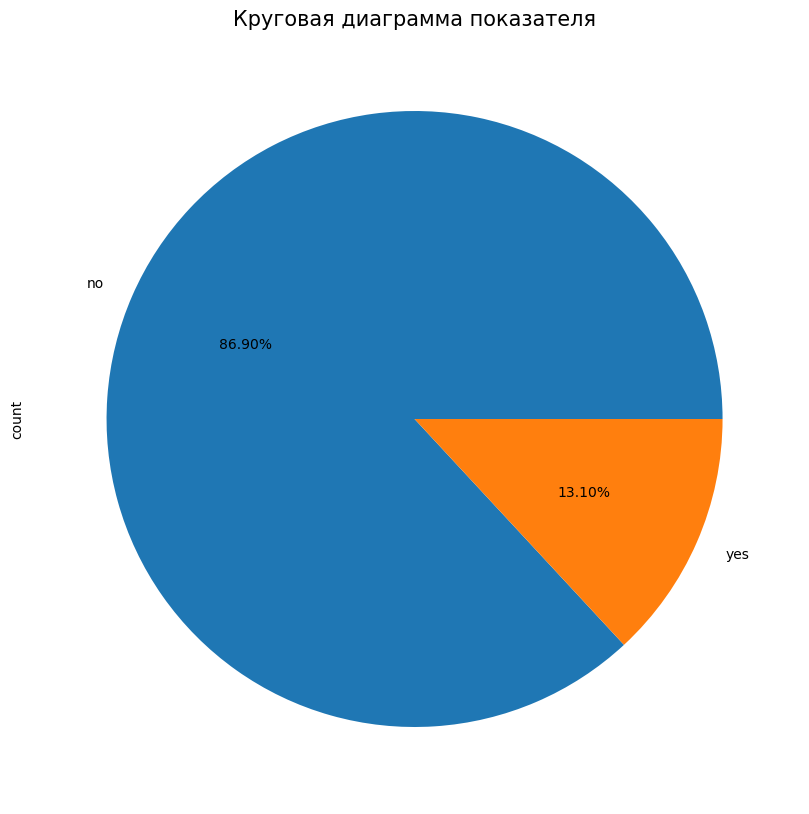

None
----------------------------------------------------------------------------------------------------


In [36]:
for i in column_for_pie:
    print(f'Исследование показателя {i}')
    print (analisys_cat_pie(test_features[i]))
    print('-'*100)

Исследование показателя employment_years


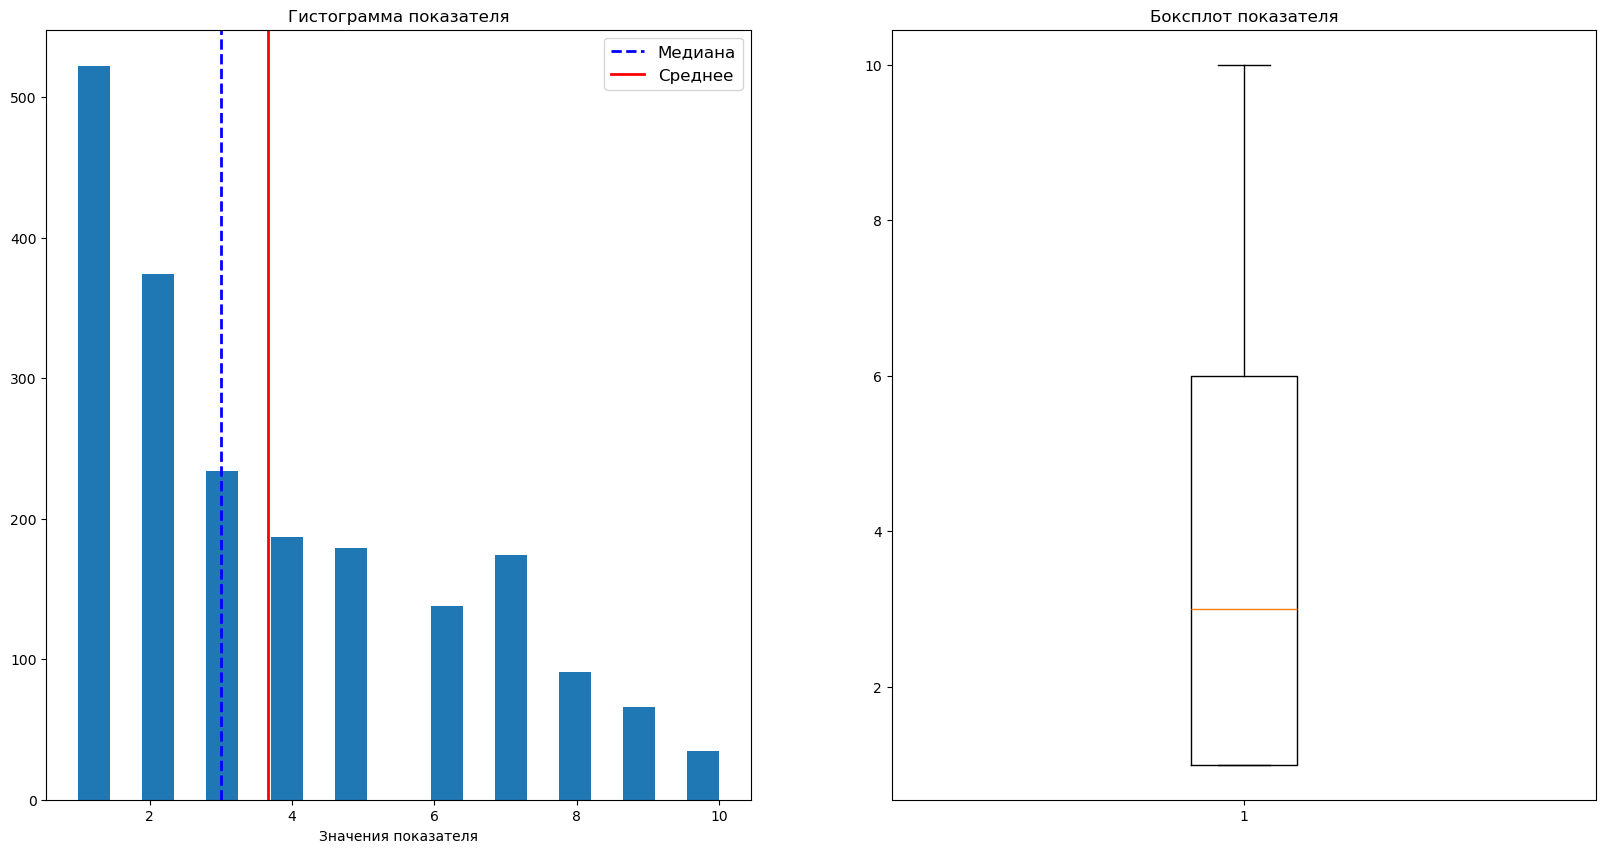

Показатели описательной статистики
count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64
None
----------------------------------------------------------------------------------------------------
Исследование показателя supervisor_evaluation


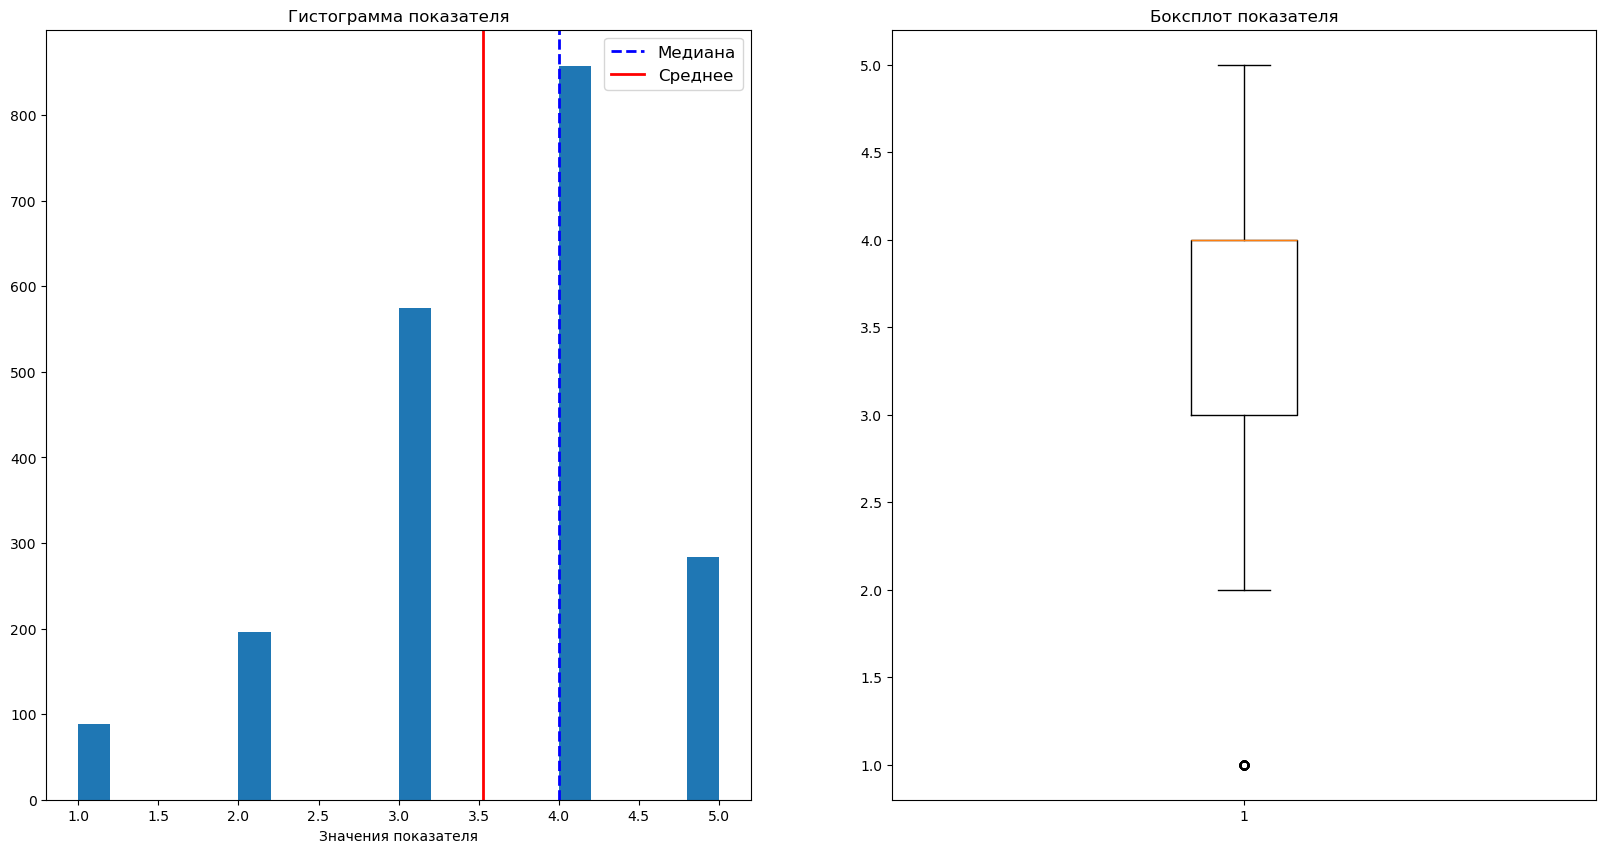

Показатели описательной статистики
count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64
None
----------------------------------------------------------------------------------------------------
Исследование показателя salary


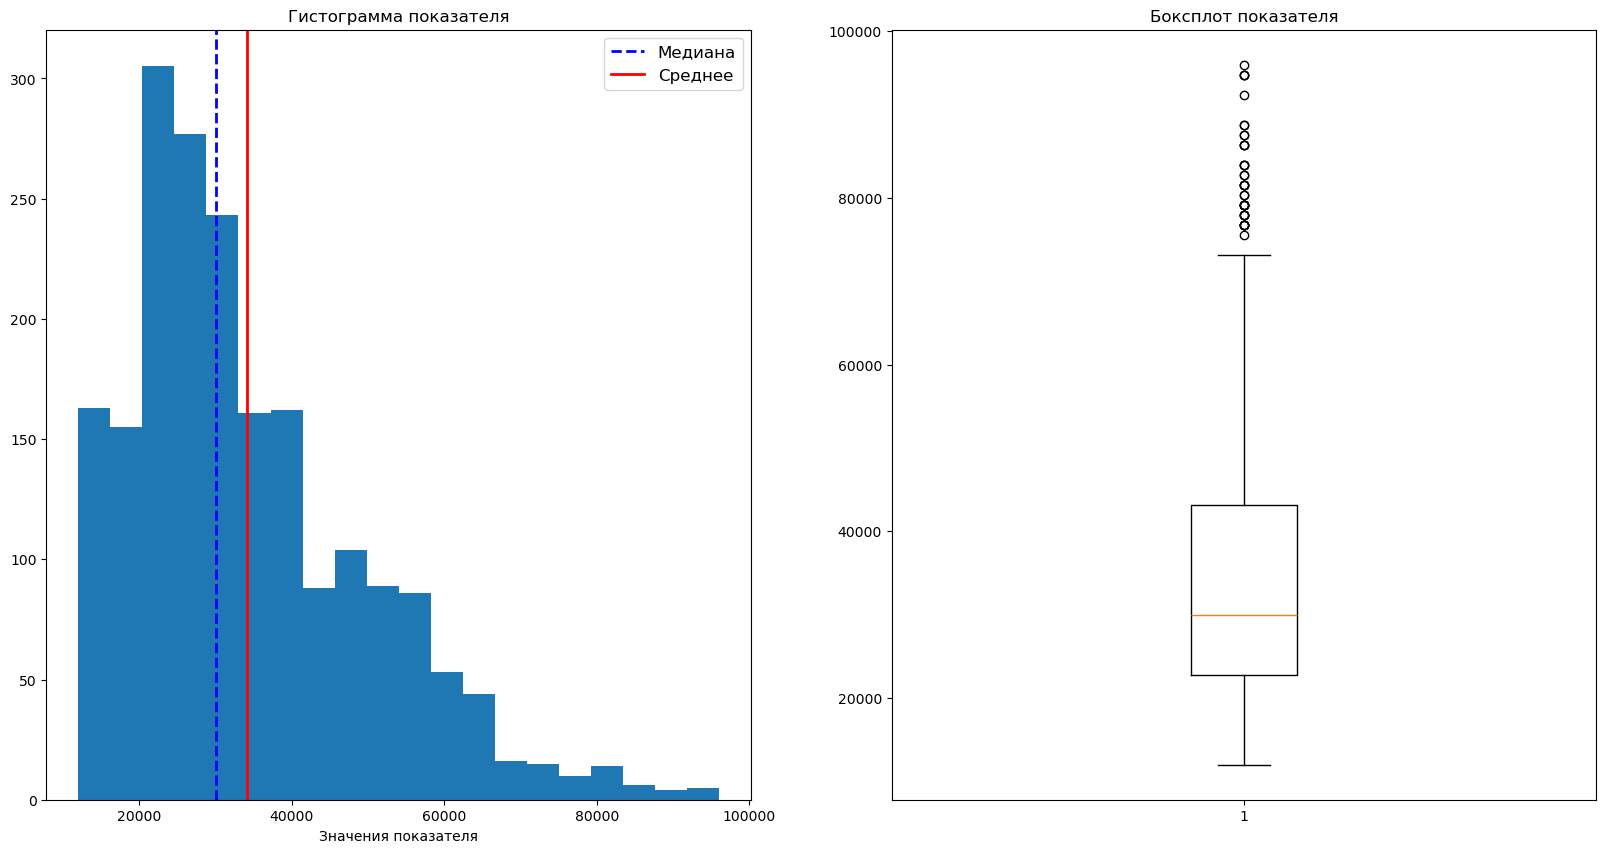

Показатели описательной статистики
count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64
None
----------------------------------------------------------------------------------------------------


In [37]:
for i in column_for_hist:
    print(f'Исследование показателя {i}')
    print (analisys_num(test_features[i]))
    print('-'*100)

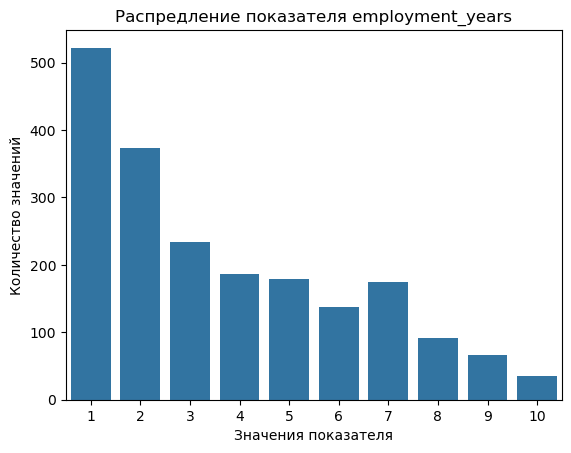

In [38]:
sns.countplot(data = test_features, x ='employment_years')
plt.title('Распредление показателя employment_years')
plt.xlabel('Значения показателя')
plt.ylabel('Количество значений')
plt.show()

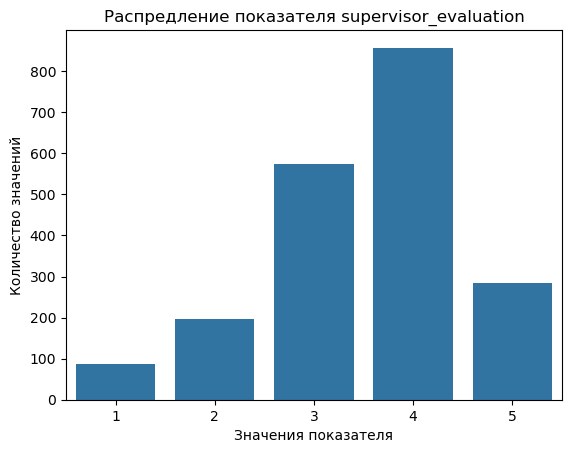

In [39]:
sns.countplot(data = test_features, x = 'supervisor_evaluation')
plt.title('Распредление показателя supervisor_evaluation')
plt.xlabel('Значения показателя')
plt.ylabel('Количество значений')
plt.show()

 </font><b>Выводы исследовательского анализа датафрейма: </b></font><br>
 
 1. Больше всего в датафремйме представлены работники из категрии sales
 
 2. Чаще всего встречаются работники уровня junior
 
 3. В большей степени работники имеют среднюю загруженность
 
 4. В течение года сотрудников не повышали.
 
 5. Большая часть сотрудников не нарушала условия трудового договора.
 
 6. В среднем в компании работают 3 года, но большая часть сотрудников работает менее 1 года
 
 7. В среднем оценка работы - 3.5, больше всего оценок - 4
 
 7. Средняя зарплата на уровне 34000 

#### Исследовательский анализ test_target_job_satisfaction_rate

In [40]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


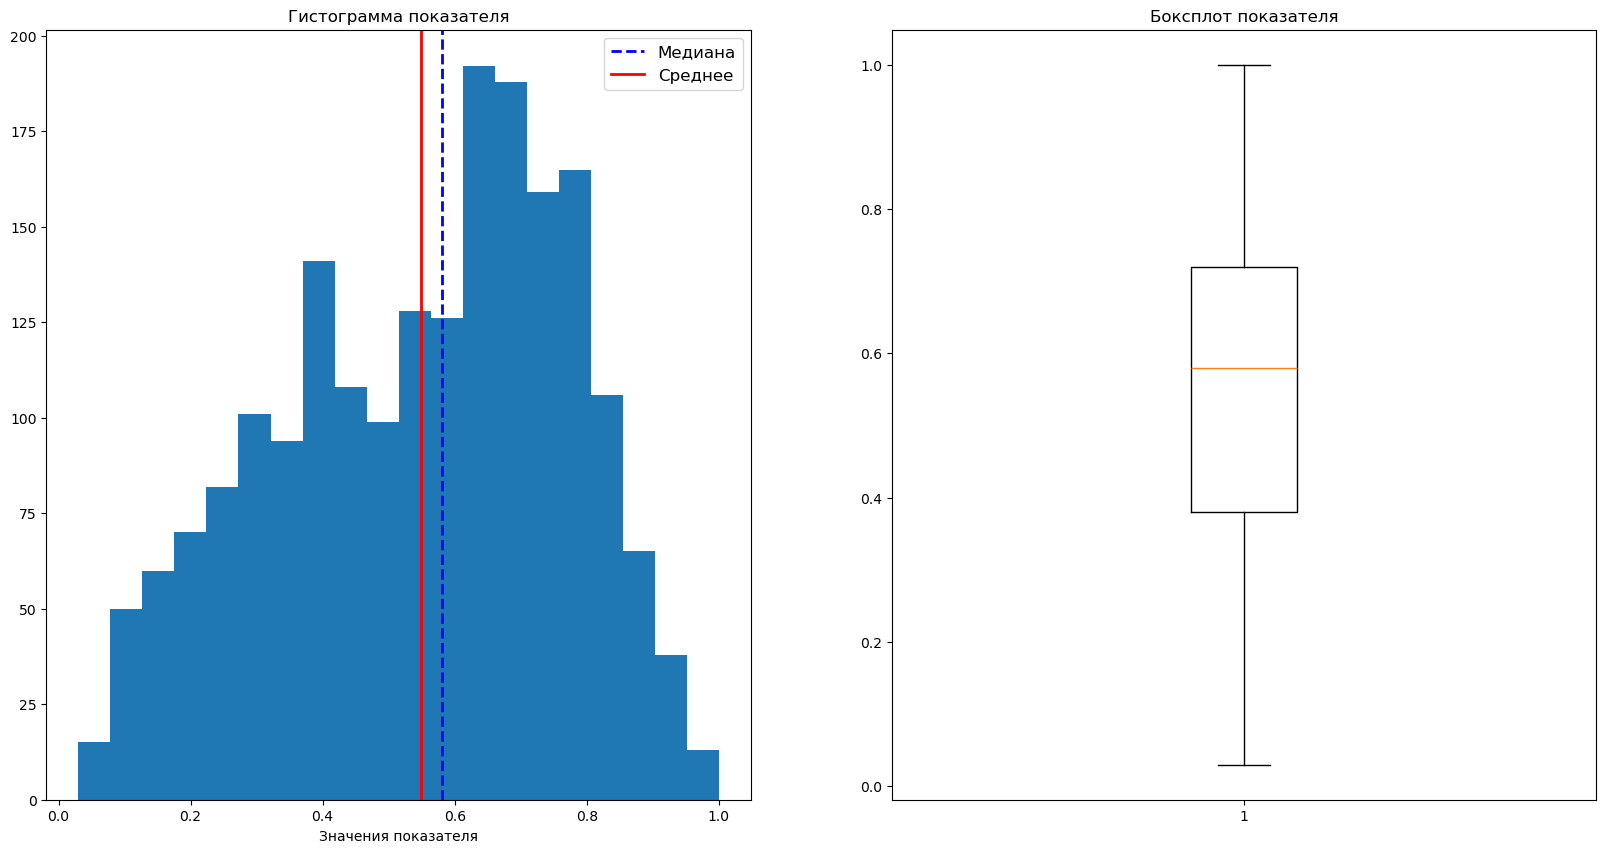

Показатели описательной статистики
count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64


In [41]:
analisys_num(test_target_job_satisfaction_rate['job_satisfaction_rate'])

 </font><b>Выводы исследовательского анализа датафрейма: </b></font><br>
 
 В среднем оценка 0.5

In [42]:
test = test_features.merge(test_target_job_satisfaction_rate, on = 'id', how = 'outer')

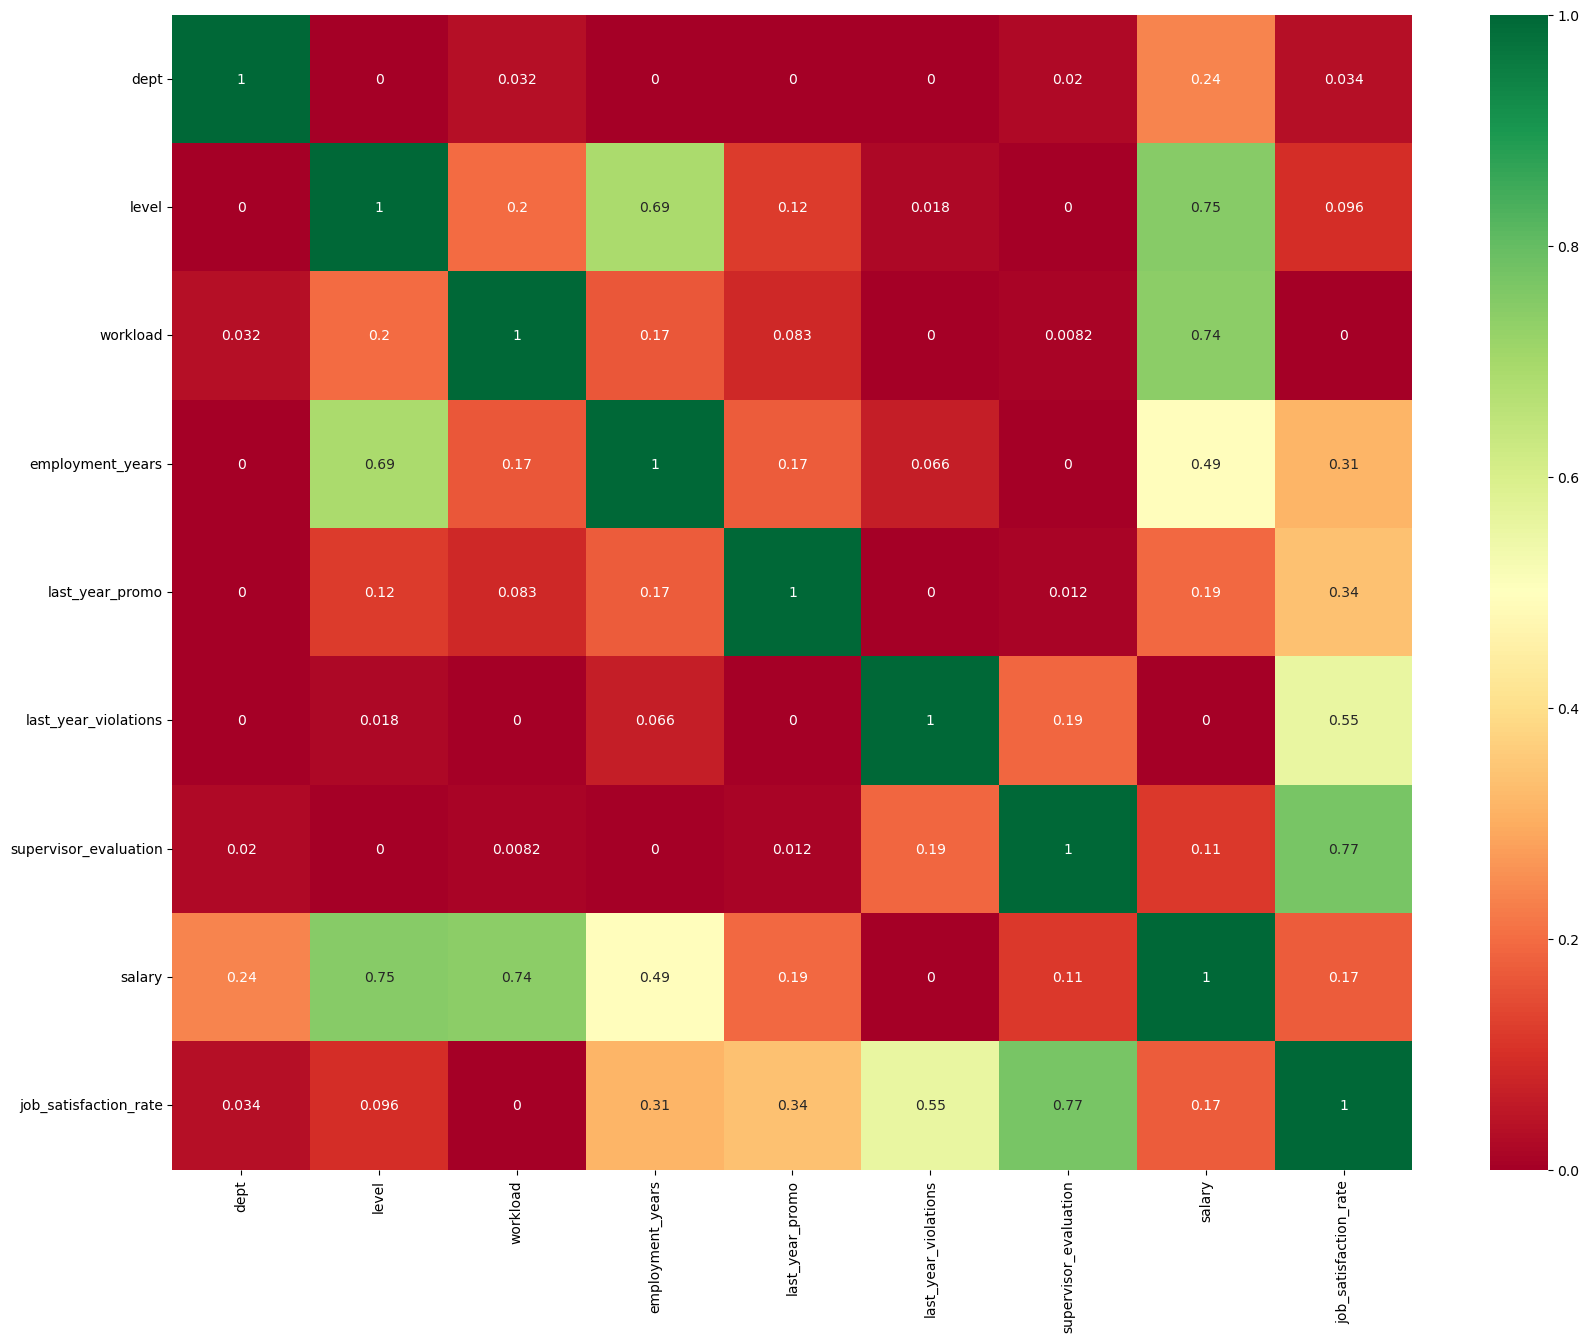

In [43]:
corr_matrix_test = test.drop('id', axis = 1).phik_matrix(interval_cols = column_num_train) 
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix_test, annot=True, cmap='RdYlGn') 
plt.show()

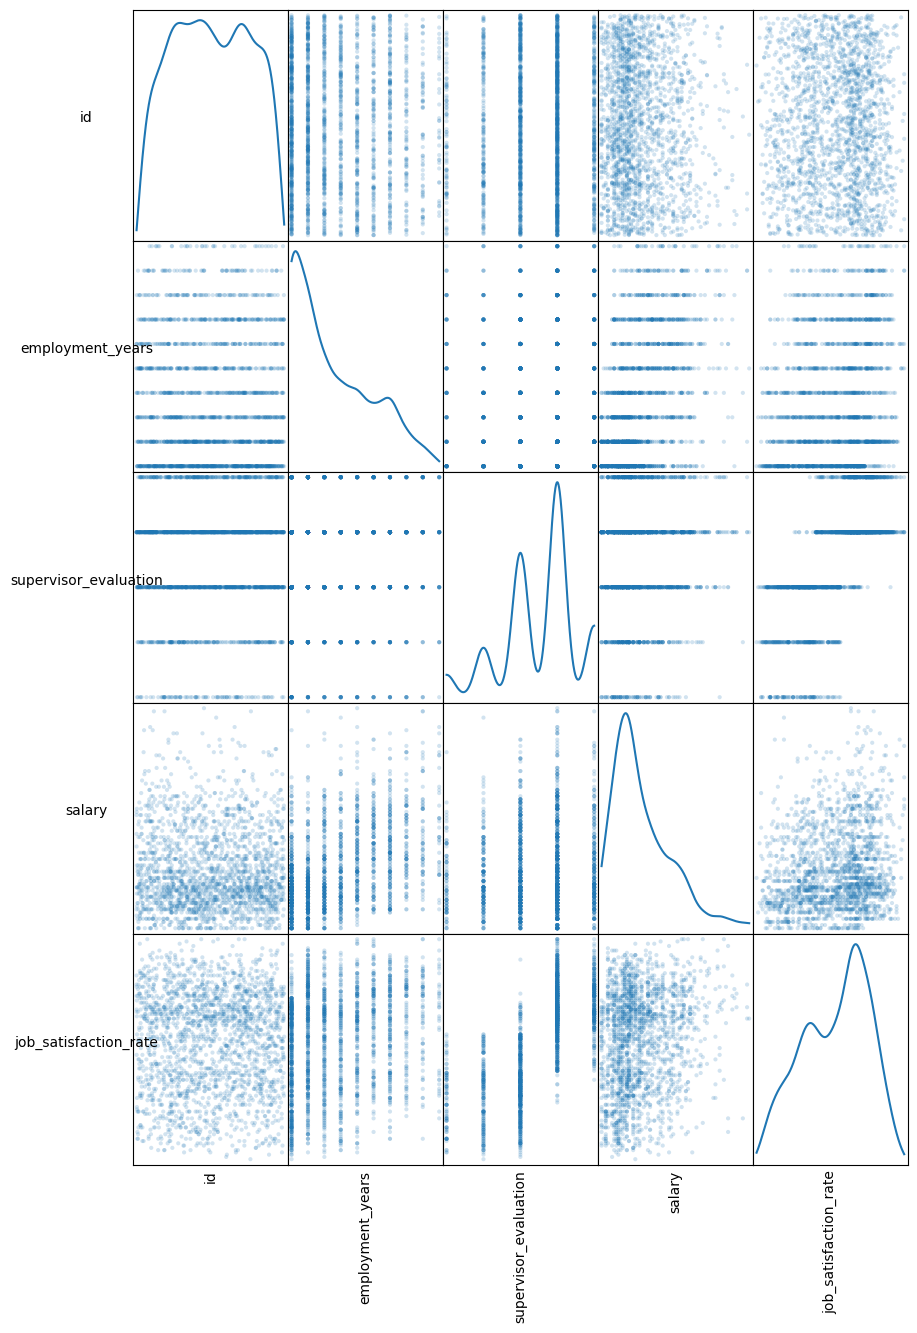

In [44]:
df_scatter_test = test
sm = pd.plotting.scatter_matrix(df_scatter_test, figsize = (10, 15), alpha=0.2, diagonal='kde')

[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]


[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

### Подготовка данных 

Для дальнейшего анализа выделим целевые и входные признаки, так же объединим датафреймы для тестовых данных, чтобы данные корректно подтянулись к индексам.


In [45]:
train = train_job_satisfaction_rate.drop('id', axis = 1)

In [46]:
train.duplicated().sum()

245

In [47]:
train = train.drop_duplicates()

In [48]:
X_train = train.drop('job_satisfaction_rate', axis = 1)
y_train = train['job_satisfaction_rate']

In [49]:
X_test = test.drop(['id','job_satisfaction_rate'], axis = 1)
y_test = test['job_satisfaction_rate']

### Обучение моделей

Пропишем пайплайны и обучим миниму две модели (линейную регрессию и дерево решений). 

In [50]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [51]:
ohe_column_one = ['dept', 'last_year_promo', 'last_year_violations']
ord_column_one = ['level', 'workload']
num_column_one = ['employment_years', 'supervisor_evaluation', 'salary']

In [52]:
ohe_pipe_one = Pipeline(
    [
        (
            'simpleImputer_ohe_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'simpleImputer_ohe_space', SimpleImputer(missing_values=" ", strategy='constant', fill_value = np.nan)
        ),
        (
            'simpleImputer_ohe_nan_two', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [53]:
ord_pipe_one = Pipeline(
    [
        (
            'simpleImputer_ohe_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'simpleImputer_ohe_space', SimpleImputer(missing_values=" ", strategy='constant', fill_value = np.nan)
        ),
        (
            'simpleImputer_ohe_nan_two', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['low', 'medium', 'high']], 
            handle_unknown='use_encoded_value', unknown_value=np.nan)
        )
    ]
)

In [54]:
data_preprocessor_one = ColumnTransformer(
    [('ohe', ohe_pipe_one, ohe_column_one),
     ('ord', ord_pipe_one, ord_column_one),
     ('num', StandardScaler(), num_column_one)], 
    remainder='passthrough') 

In [55]:
# второй шаг пайплайна
pipe_final_one = Pipeline([
    ('preprocessor', data_preprocessor_one),
    ('models', LinearRegression())])

In [56]:
param_grid_one = [
    {   'models': [LinearRegression()],
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(),'passthrough']  
  
    }]

In [57]:
# создадим метрику SMAPE
def smape(y_pred, y_test):
    return (100/len(y_test))* np.sum(np.abs(y_test - y_pred)/((np.abs(y_test) + np.abs(y_pred))/2)) 
                                     

smape_scor = make_scorer(score_func=smape, greater_is_better=False)

In [58]:
#запустим автоматический подбор параметров
random_search = RandomizedSearchCV(
    pipe_final_one, 
    param_grid_one, 
    cv=5,
    scoring=smape_scor,
    n_jobs=-1,
    n_iter = 100,
    random_state = RANDOM_STATE)

random_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print('Параметры лучшей модели:\n',random_search.best_params_)
print('SMAPE лучшей модели на кросс-валидации:\n',round((random_search.best_score_ * (-1)), 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_space',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 missing_values=' ',
                                                                                 strategy='constant')),
                                                                  ('simpleImputer_ohe_nan_two',
                                                                   SimpleImputer(strategy='most_frequent')),
                

In [59]:
pd.DataFrame(random_search.cv_results_)[
    ['std_test_score', 'rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

std_test_score  rank_test_score                            param_models  \
2         0.589278                1  DecisionTreeRegressor(random_state=42)   
8         0.719814                2  DecisionTreeRegressor(random_state=42)   
66        0.778945                3  DecisionTreeRegressor(random_state=42)   
96        0.651692                4  DecisionTreeRegressor(random_state=42)   
83        0.651692                4  DecisionTreeRegressor(random_state=42)   
..             ...              ...                                     ...   
15        0.683583               93  DecisionTreeRegressor(random_state=42)   
16        0.683583               93  DecisionTreeRegressor(random_state=42)   
55        0.683583               98  DecisionTreeRegressor(random_state=42)   
84        0.643241               99  DecisionTreeRegressor(random_state=42)   
9         0.862184              100  DecisionTreeRegressor(random_state=42)   

    mean_test_score                                             params  
2        -15.630721  {'preprocessor__num': StandardScaler(), 'model...  
8        -15.683128  {'preprocessor__num': MinMaxScaler(), 'models_...  
66       -15.684454  {'preprocessor__num': StandardScaler(), 'model...  
96       -15.708997  {'preprocessor__num': MinMaxScaler(), 'models_...  
83       -15.708997  {'preprocessor__num': MinMaxScaler(), 'models_...  
..              ...                                                ...  
15       -23.965105  {'preprocessor__num': 'passthrough', 'models__...  
16       -23.965105  {'preprocessor__num': StandardScaler(), 'model...  
55       -23.965105  {'preprocessor__num': RobustScaler(), 'models_...  
84       -24.488894  {'preprocessor__num': 'passthrough', 'models__...  
9        -24.712111  {'preprocessor__num': 'passthrough', 'models__...  

[100 rows x 5 columns]

In [60]:
y_pred = random_search.predict(X_test)

In [61]:
smape_test = smape(y_pred, y_test)

print(f'SMAPE лучшей модели на тренировочных данных {round((smape_test), 2)}')

SMAPE лучшей модели на тренировочных данных 14.81


### Выводы

Отобрана лучшая модель  DecisionTreeRegressor с гиперпараметрами random_state=42, max_depth =  12, max_features = 8, в препроцессе необходимо использовать StandardScaler()

## Предсказание увольнения сотрудника из компании

### Загрузка и первичный обзор данных

In [62]:
try:
    train_quit_two  =  pd.read_csv('C:/Users/Zenbook/Desktop/Проекты/train_quit.csv')
    test_features_two = pd.read_csv('C:/Users/Zenbook/Desktop/Проекты/test_features_2.csv')
    test_target_quit_two = pd.read_csv('C:/Users/Zenbook/Desktop/Проекты/test_target_quit.csv')
except:
    print('Произошла ошибка')

In [63]:
train_quit_two.head(10)

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   
5  699916       sales  junior      low                 1              no   
6  417070  technology  middle   medium                 8              no   
7  165489       sales  middle      low                 4              no   
8  996399   marketing  middle      low                 7              no   
9  613206  technology  middle   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no  
5                  yes                      3   18000  yes  
6                   no                      2   44400   no  
7                   no                      5   19200   no  
8                   no                      4   25200   no  
9                   no                      3   45600  yes

In [64]:
test_features_two.head(10)

id        dept   level workload  employment_years last_year_promo  \
0  485046   marketing  junior   medium                 2              no   
1  686555          hr  junior   medium                 1              no   
2  467458       sales  middle      low                 5              no   
3  418655       sales  middle      low                 6              no   
4  789145          hr  middle   medium                 5              no   
5  429973  purchasing  middle   medium                 6              no   
6  850699  technology  junior   medium                 3              no   
7  500791       sales  middle     high                 9              no   
8  767867   marketing  middle     high                 3              no   
9  937235       sales  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800  
5                   no                      3   42000  
6                   no                      3   26400  
7                   no                      4   49200  
8                  yes                      4   62400  
9                  yes                      3   26400

In [65]:
test_target_quit_two.head(10)

id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes
5  223063   no
6  810370   no
7  998900   no
8  578329   no
9  648850   no

### Предобработка данных

#### Предобработка данных в датафрейме train_quit

In [66]:
train_quit_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [67]:
train_quit_two.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [68]:
train_quit_two.duplicated().sum()

0

In [69]:
column_train_two = ['id', 'dept', 'level',
                   'workload', 'last_year_promo',
                   'last_year_violations']
for i in column_train:
    print(f'Уникальные значения показателя {i}')
    print(train_quit_two[i].unique())
    print (train_quit_two[i].nunique())
    print('-'*100)

Уникальные значения показателя id
[723290 814010 155091 ... 536432 692133 853842]
4000
----------------------------------------------------------------------------------------------------
Уникальные значения показателя dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']
5
----------------------------------------------------------------------------------------------------
Уникальные значения показателя level
['middle' 'junior' 'sinior']
3
----------------------------------------------------------------------------------------------------
Уникальные значения показателя workload
['high' 'medium' 'low']
3
----------------------------------------------------------------------------------------------------
Уникальные значения показателя last_year_promo
['no' 'yes']
2
----------------------------------------------------------------------------------------------------
Уникальные значения показателя last_year_violations
['no' 'yes']
2
------------------------------------------------------

Датафрейм содержит 4000 id, не содержит пропусков и дублей

#### Предобработка в датафрейме test_features

In [70]:
test_features_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [71]:
test_features_two.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [72]:
column_test_two = ['id', 'dept', 'level',
                   'workload', 'last_year_promo',
                   'last_year_violations']
for i in column_train:
    print(f'Уникальные значения показателя {i}')
    print(test_features_two[i].unique())
    print (test_features_two[i].nunique())
    print('-'*100)

Уникальные значения показателя id
[485046 686555 467458 ... 305653 160233 771859]
2000
----------------------------------------------------------------------------------------------------
Уникальные значения показателя dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
6
----------------------------------------------------------------------------------------------------
Уникальные значения показателя level
['junior' 'middle' 'sinior' nan]
3
----------------------------------------------------------------------------------------------------
Уникальные значения показателя workload
['medium' 'low' 'high' ' ']
4
----------------------------------------------------------------------------------------------------
Уникальные значения показателя last_year_promo
['no' 'yes']
2
----------------------------------------------------------------------------------------------------
Уникальные значения показателя last_year_violations
['no' 'yes']
2
--------------------------------------

In [73]:
#заменим пробелы в данных на Nan
test_features_two['dept'] = test_features['dept'].replace(' ', np.nan)

In [74]:
test_features_two['workload'] = test_features['workload'].replace(' ', np.nan)

Датайрефм содержит 2000 уникальных id, не содержит дубликаов, пропуски заполнем на этапе пайплайна

#### Преобработка данных в датафрейме test_target_quit_two

In [75]:
test_target_quit_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [76]:
test_target_quit_two.isna().sum()

id      0
quit    0
dtype: int64

In [77]:
test_target_quit_two.duplicated().sum()

0

#### Общие выводы по разделу

Была проведена предподготовка данных в трех датафреймах. Пропуски типа Nan на данных момент были оставлены, но пробелы заполнены.

### Исследовательский анализ

#### Исследовательский анализ датафрейма train_quit_two

In [78]:
train_quit_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [79]:
column_for_plot_two = ['dept', 'level', 'workload']
column_for_pie_two = ['last_year_promo','last_year_violations']
column_for_hist_two = ['salary', 'quit']

Исследование показателя dept


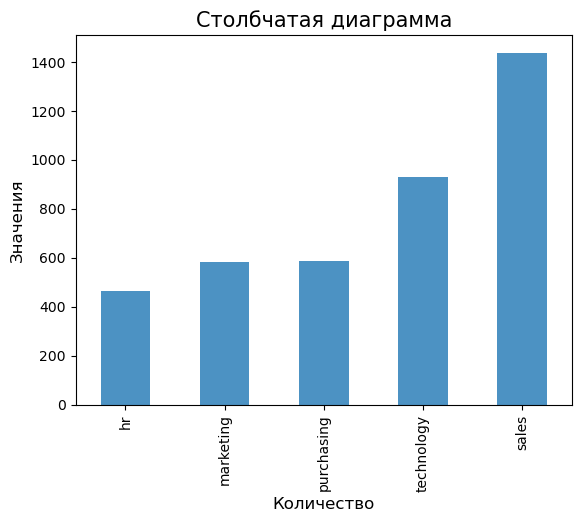

None
----------------------------------------------------------------------------------------------------
Исследование показателя level


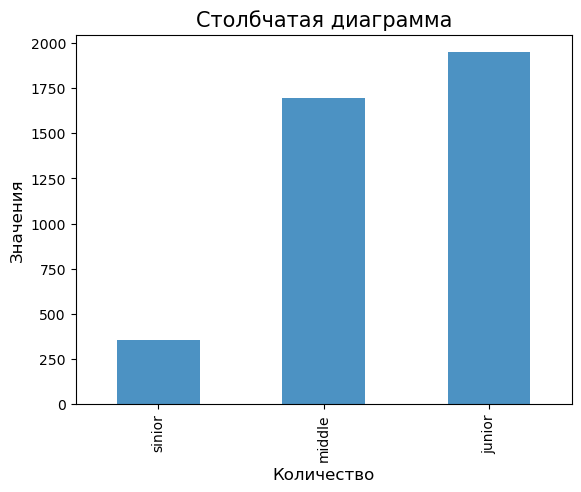

None
----------------------------------------------------------------------------------------------------
Исследование показателя workload


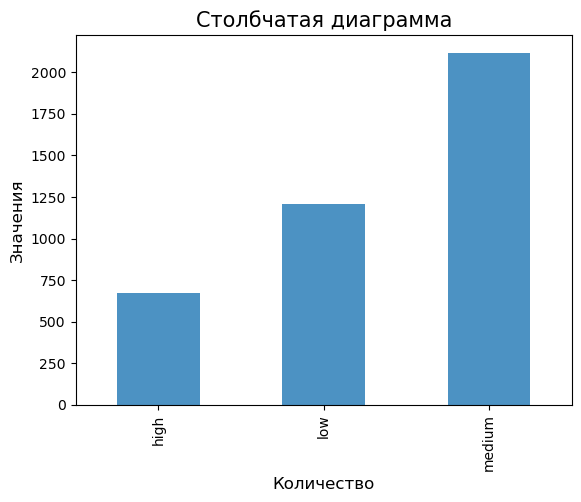

None
----------------------------------------------------------------------------------------------------


In [80]:
for i in column_for_plot_two:
    print(f'Исследование показателя {i}')
    print (analisys_cat_plot(train_quit_two[i]))
    print('-'*100)

Исследование показателя last_year_promo


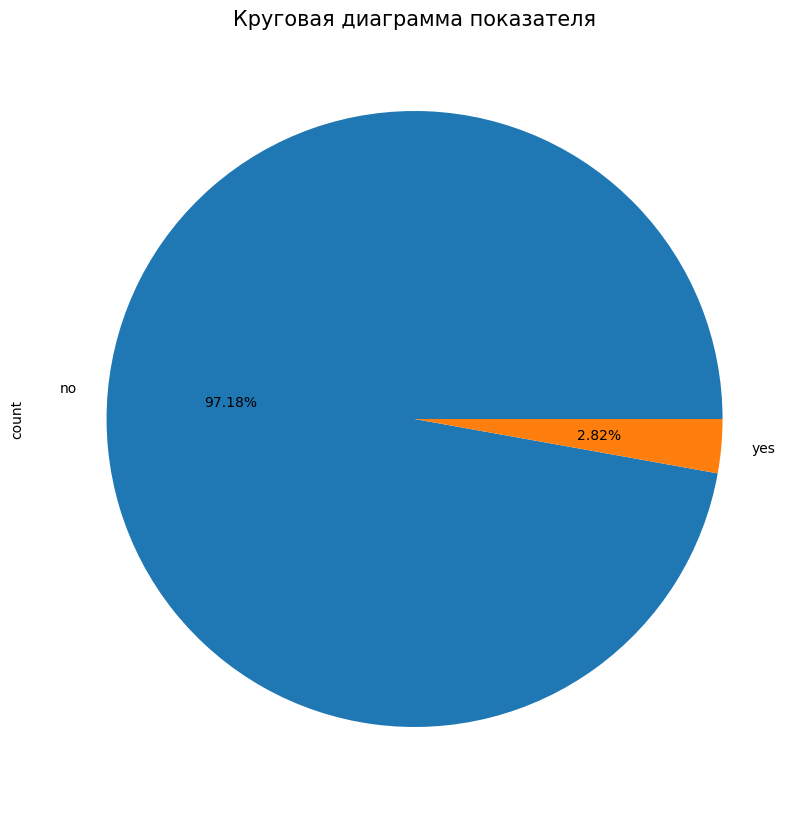

None
----------------------------------------------------------------------------------------------------
Исследование показателя last_year_violations


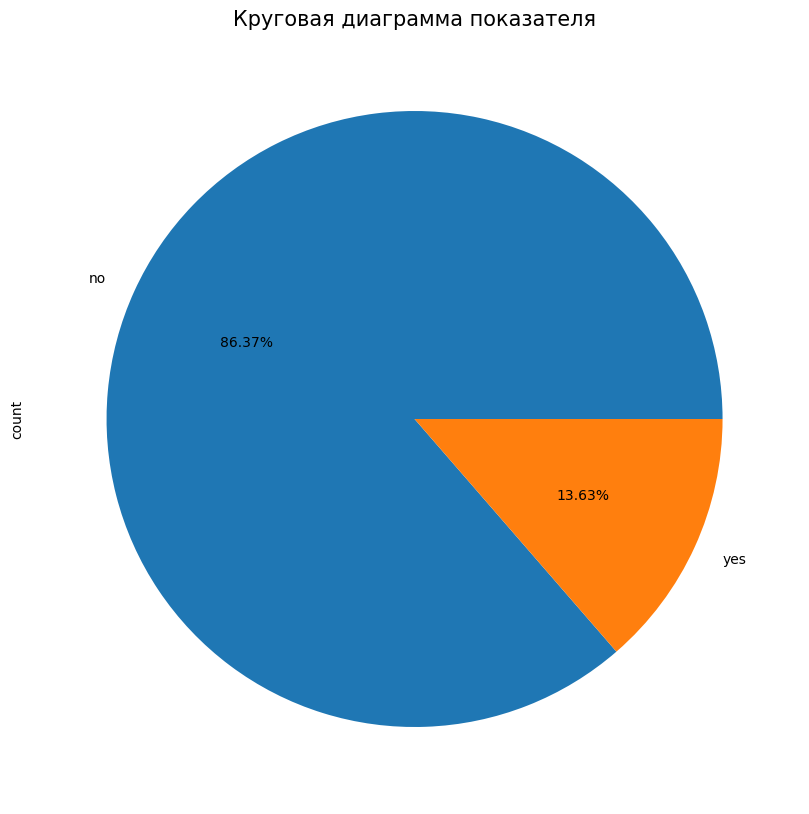

None
----------------------------------------------------------------------------------------------------


In [81]:
for i in column_for_pie:
    print(f'Исследование показателя {i}')
    print (analisys_cat_pie(train_quit_two[i]))
    print('-'*100)

Исследование показателя employment_years


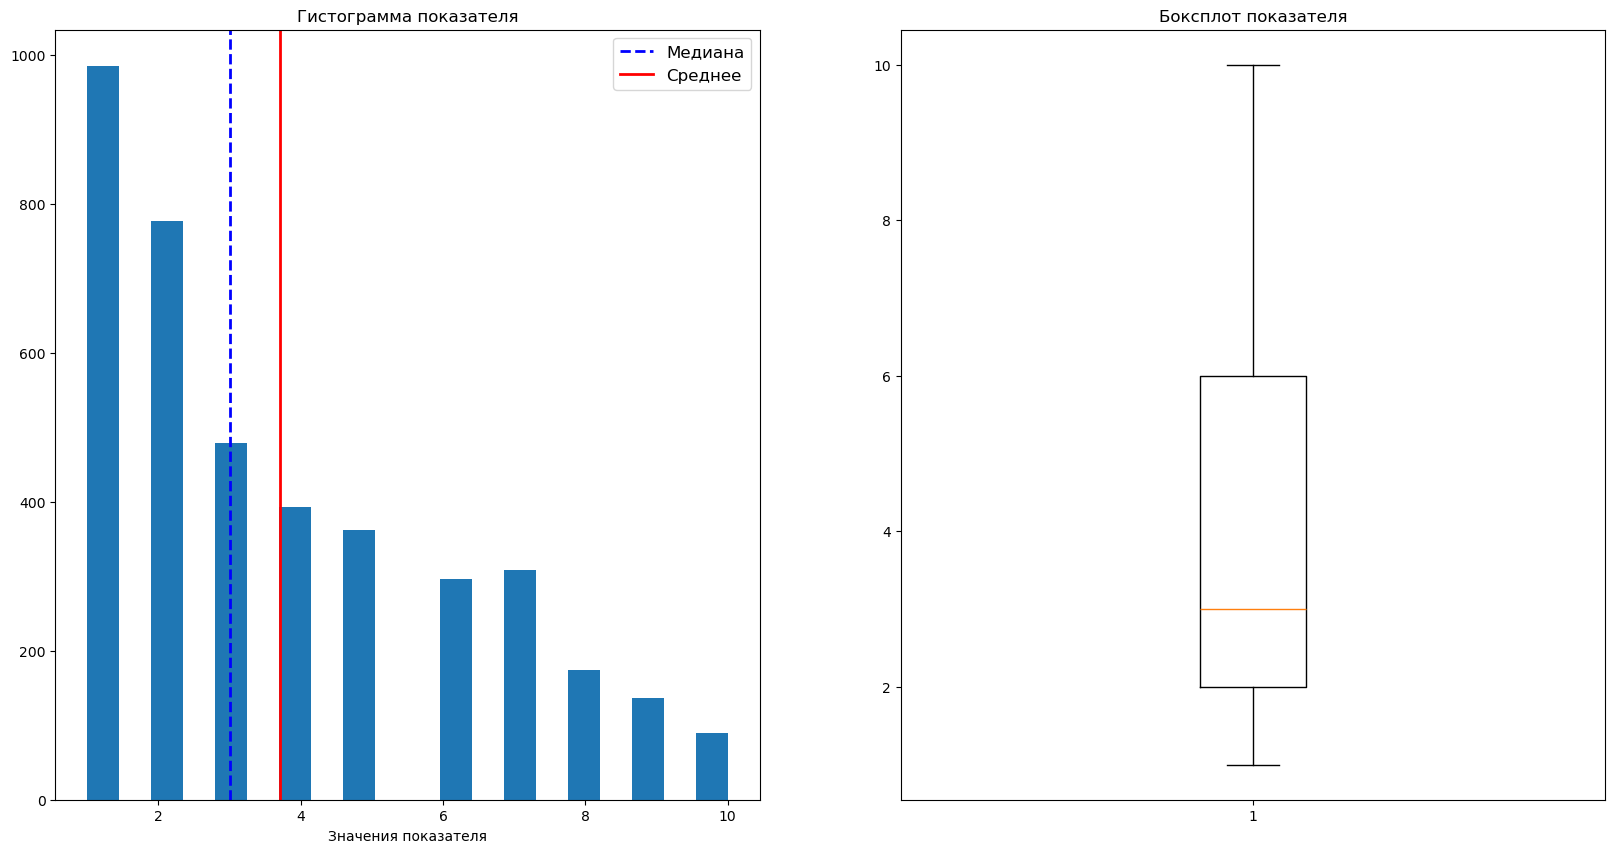

Показатели описательной статистики
count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64
None
----------------------------------------------------------------------------------------------------
Исследование показателя supervisor_evaluation


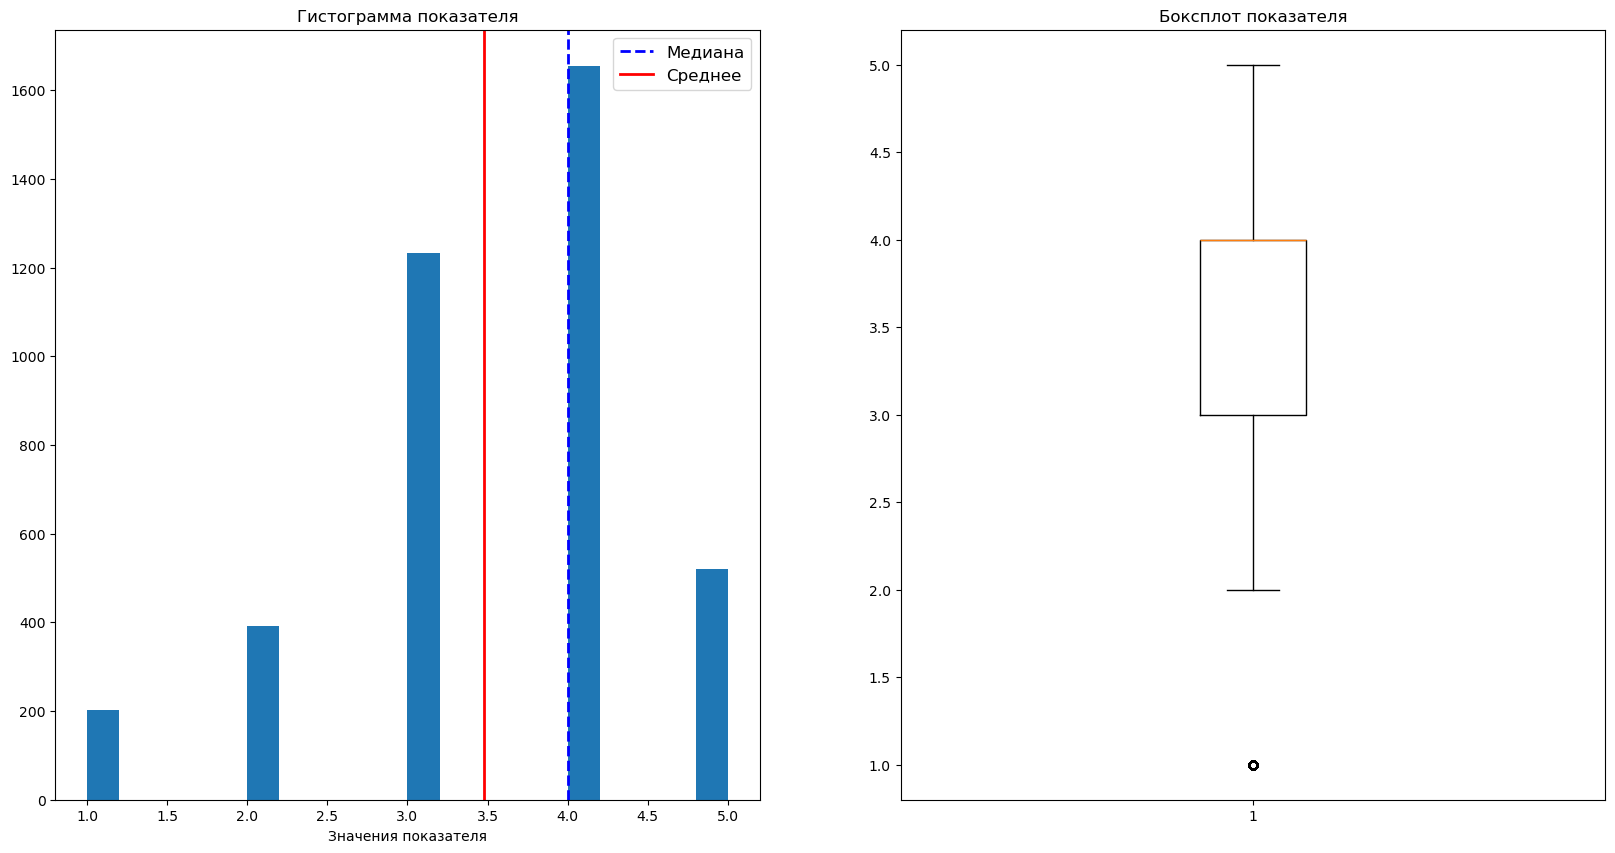

Показатели описательной статистики
count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64
None
----------------------------------------------------------------------------------------------------
Исследование показателя salary


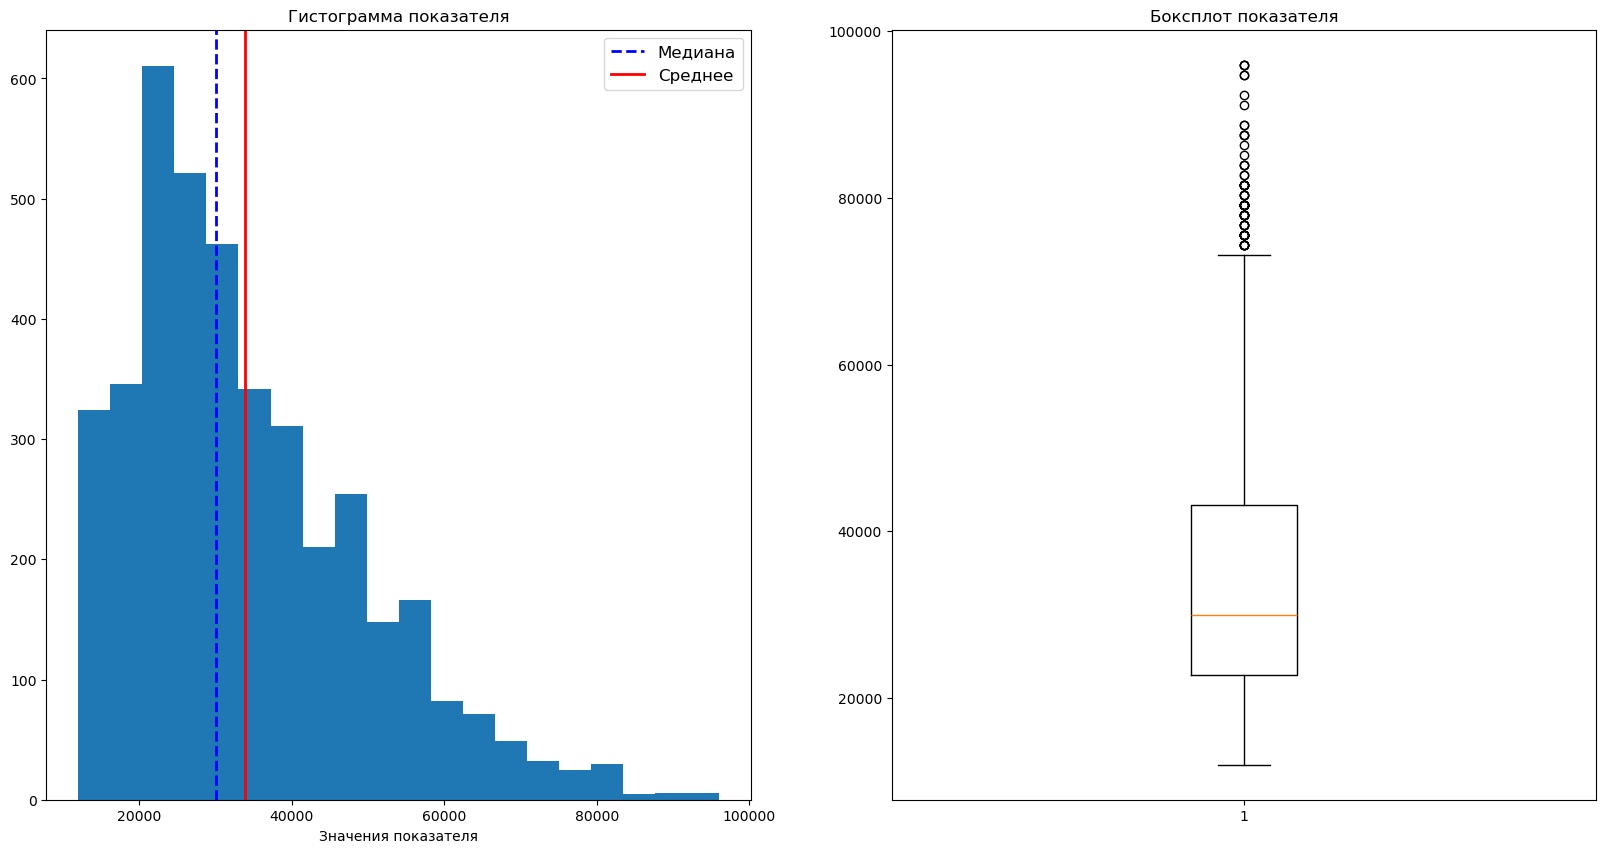

Показатели описательной статистики
count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64
None
----------------------------------------------------------------------------------------------------


In [82]:
for i in column_for_hist:
    print(f'Исследование показателя {i}')
    print (analisys_num(train_quit_two[i]))
    print('-'*100)

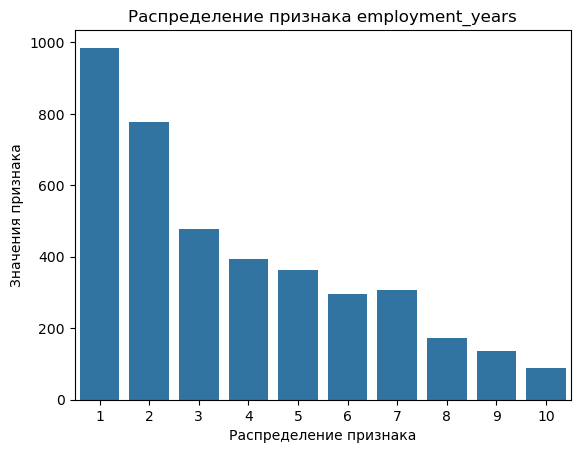

In [83]:
sns.countplot(data = train_quit_two, x ='employment_years')
plt.title('Распределение признака employment_years')
plt.xlabel('Распределение признака')
plt.ylabel('Значения признака')
plt.show()

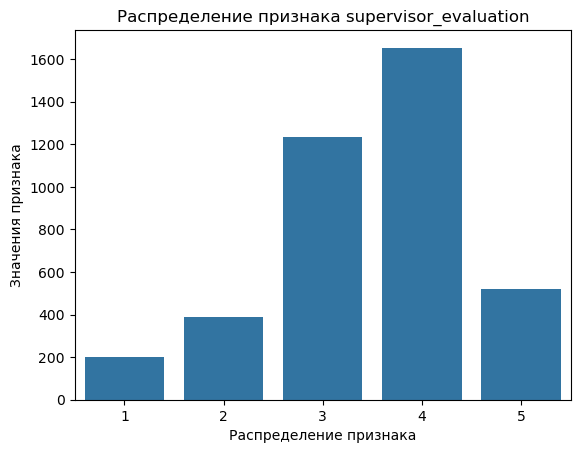

In [84]:
sns.countplot(data = train_quit_two, x ='supervisor_evaluation')
plt.title('Распределение признака supervisor_evaluation')
plt.xlabel('Распределение признака')
plt.ylabel('Значения признака')
plt.show()

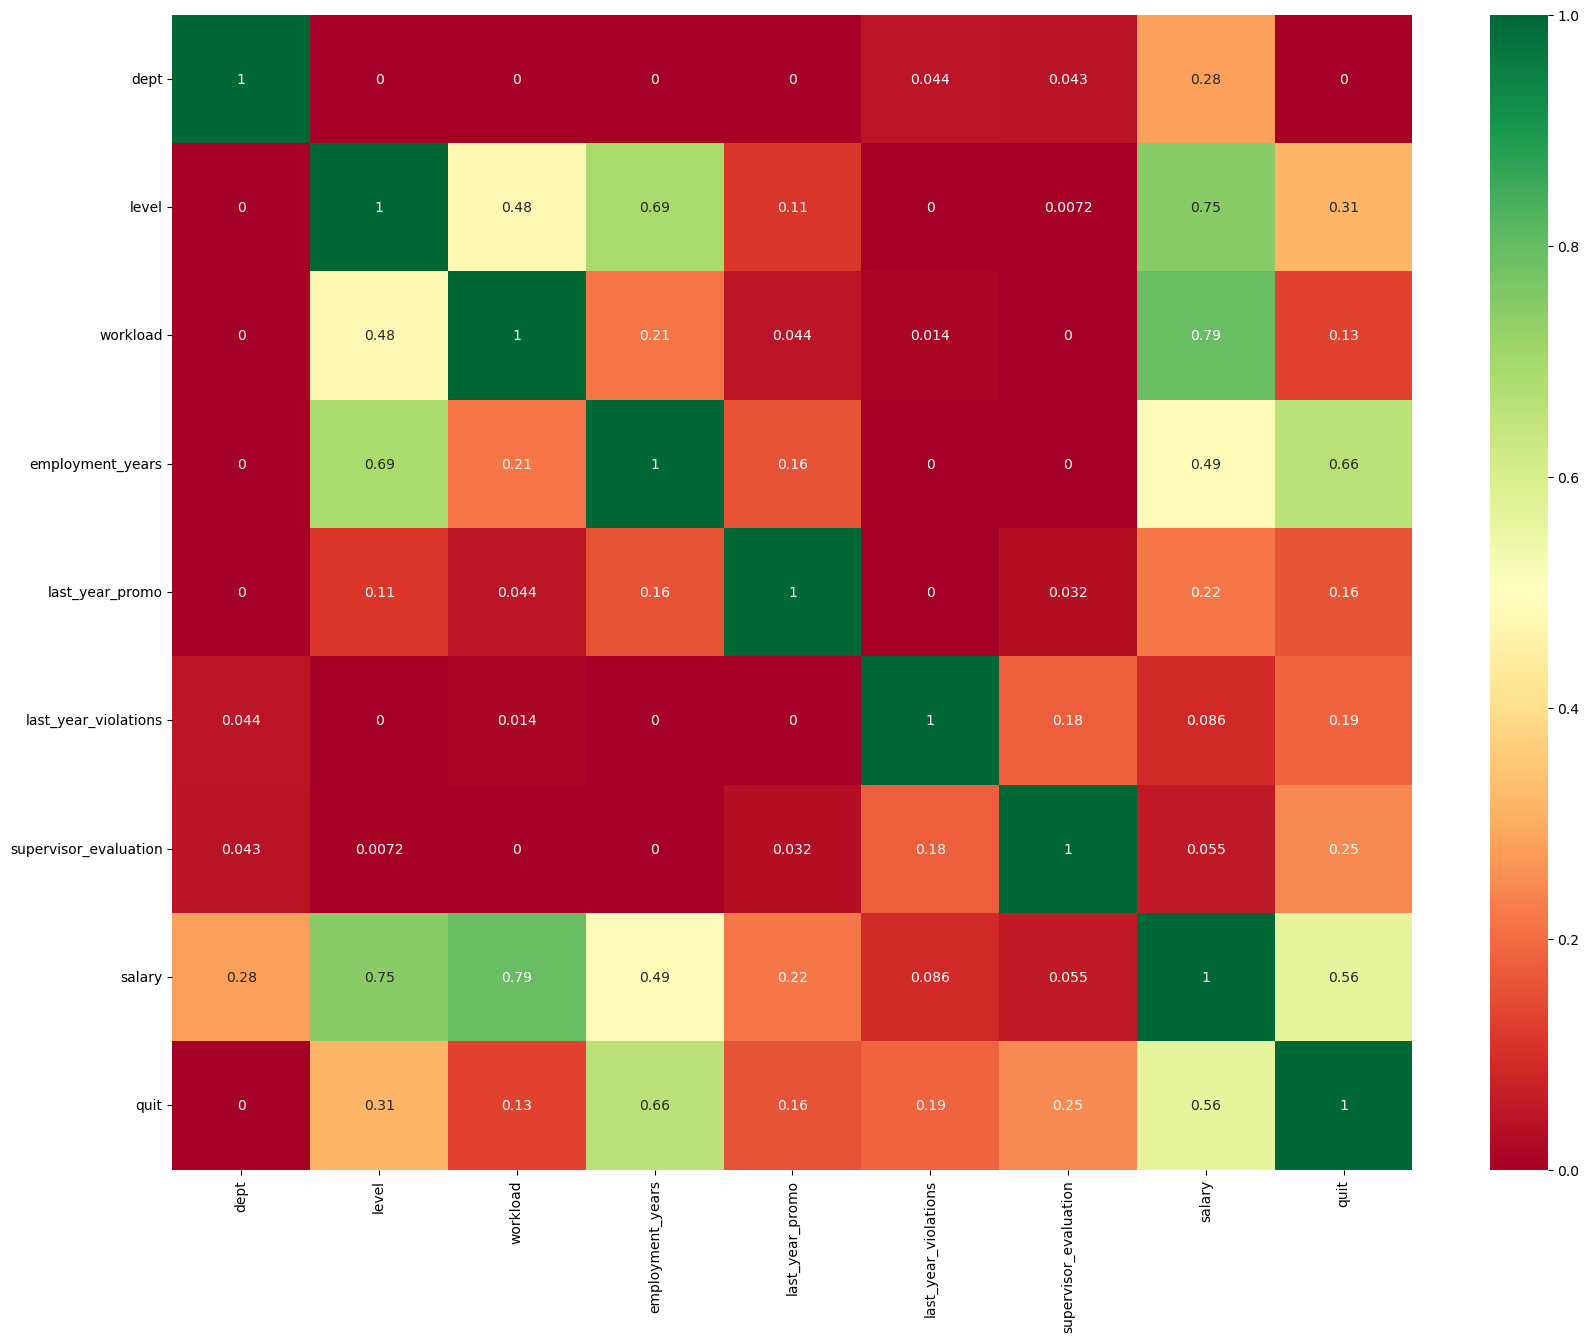

In [85]:
corr_matrix_two = train_quit_two.drop('id', axis = 1).phik_matrix(interval_cols = column_num_train)
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix_two, annot=True, cmap='RdYlGn') 
plt.show()

 </font><b>Промежуточные выводы исследовательского анализа: </b></font><br>
 
 Больше всего в датафрейме представлены в основном sales с средней нагрузкой на уровне junior. Больше всего взаимосвязь удовлетворенности сотрудника зависит от оценки руководителя и повышения в течение года. 

#### Исследовательский анализ датафрейма test_features_two

In [86]:
test_features_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [87]:
column_for_plot_two_test = ['dept', 'level', 'workload']
column_for_pie_two_test = ['last_year_promo','last_year_violations']
column_for_hist_two_test = ['salary']

Исследование показателя dept


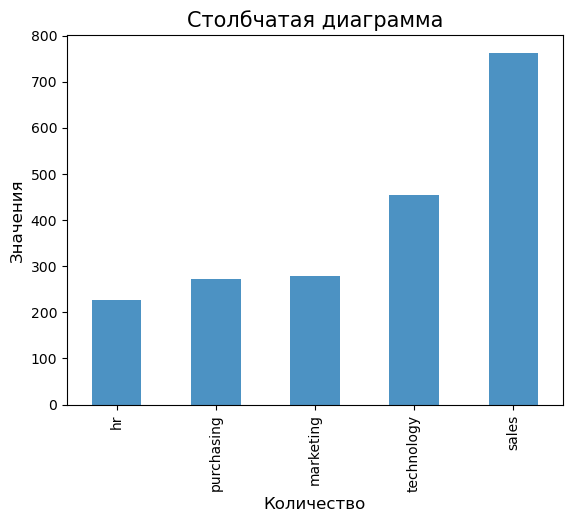

None
----------------------------------------------------------------------------------------------------
Исследование показателя level


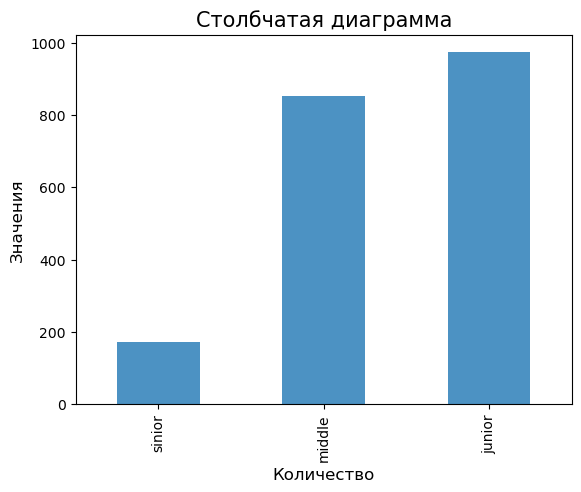

None
----------------------------------------------------------------------------------------------------
Исследование показателя workload


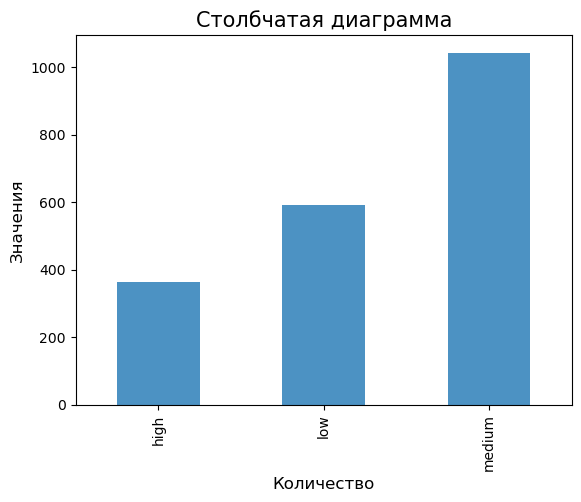

None
----------------------------------------------------------------------------------------------------


In [88]:
for i in column_for_plot_two_test:
    print(f'Исследование показателя {i}')
    print (analisys_cat_plot(test_features_two[i]))
    print('-'*100)

Исследование показателя last_year_promo


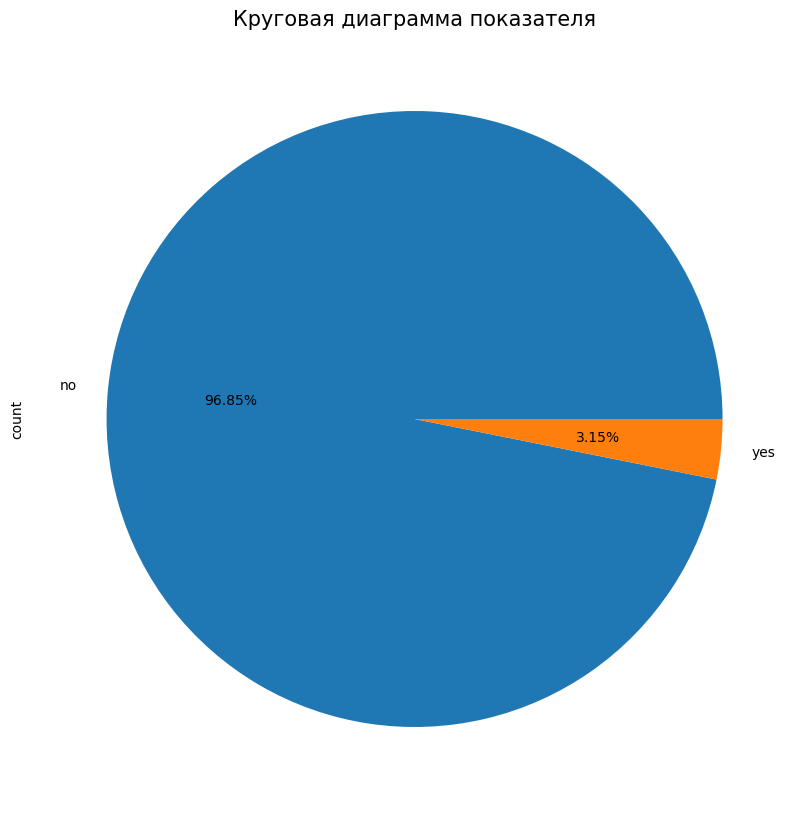

None
----------------------------------------------------------------------------------------------------
Исследование показателя last_year_violations


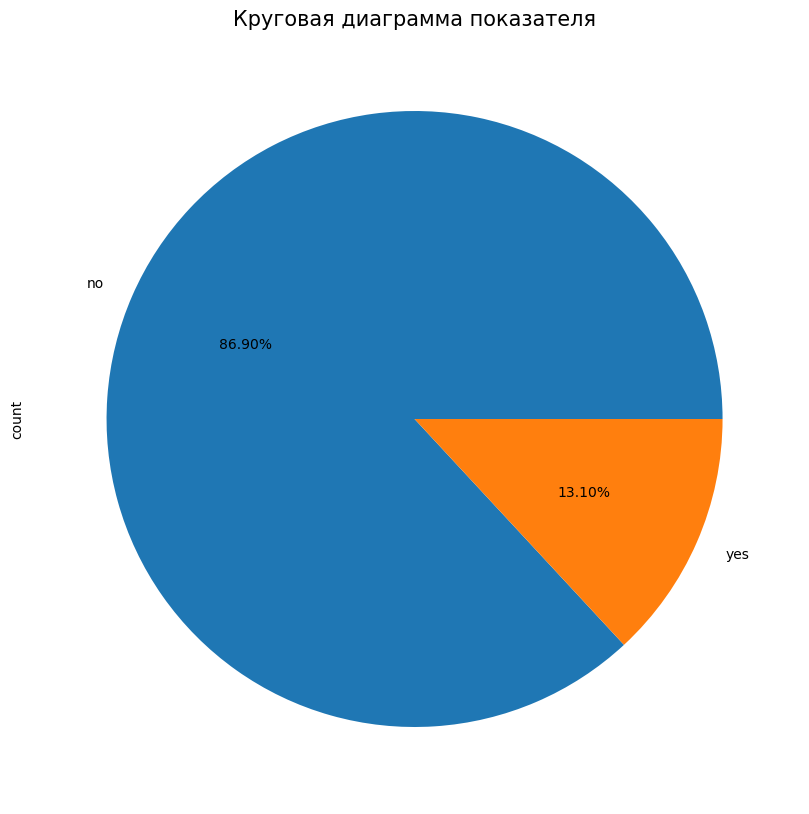

None
----------------------------------------------------------------------------------------------------


In [89]:
for i in column_for_pie_two_test:
    print(f'Исследование показателя {i}')
    print (analisys_cat_pie(test_features_two[i]))
    print('-'*100)

Исследование показателя salary


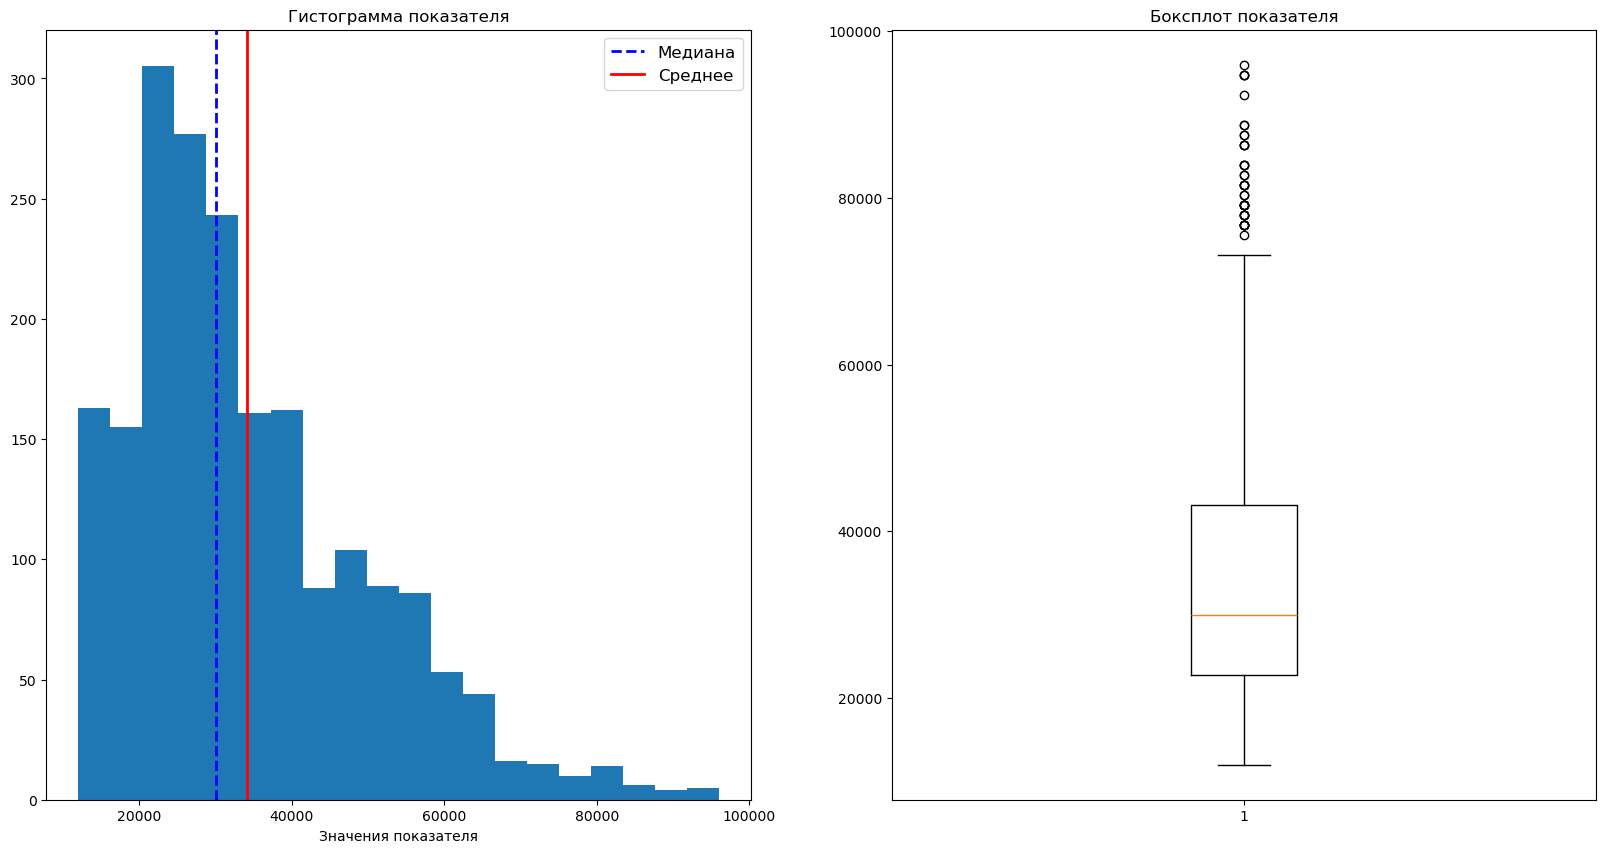

Показатели описательной статистики
count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64
None
----------------------------------------------------------------------------------------------------


In [90]:
for i in column_for_hist_two_test :
    print(f'Исследование показателя {i}')
    print (analisys_num(test_features_two[i]))
    print('-'*100)

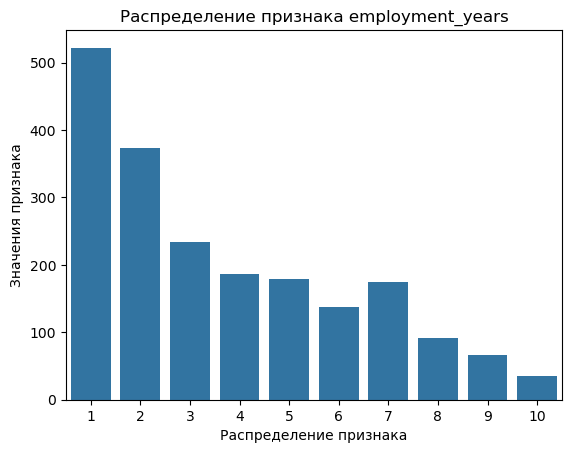

In [91]:
sns.countplot(data = test_features_two, x ='employment_years')
plt.title('Распределение признака employment_years')
plt.xlabel('Распределение признака')
plt.ylabel('Значения признака')
plt.show()

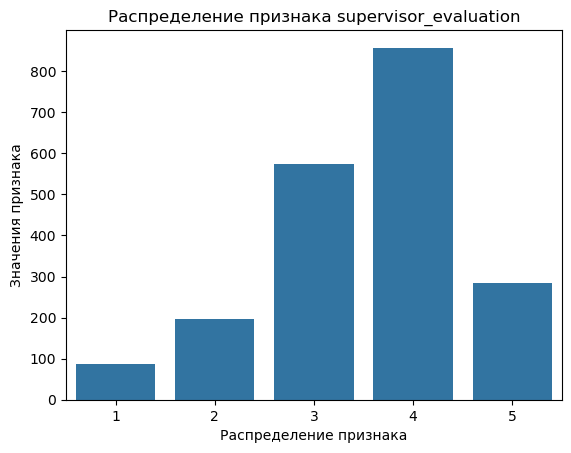

In [92]:
sns.countplot(data = test_features_two, x ='supervisor_evaluation')
plt.title('Распределение признака supervisor_evaluation')
plt.xlabel('Распределение признака')
plt.ylabel('Значения признака')
plt.show()

In [93]:
test_class = test_features_two.merge(test_target_quit_two, on = 'id')

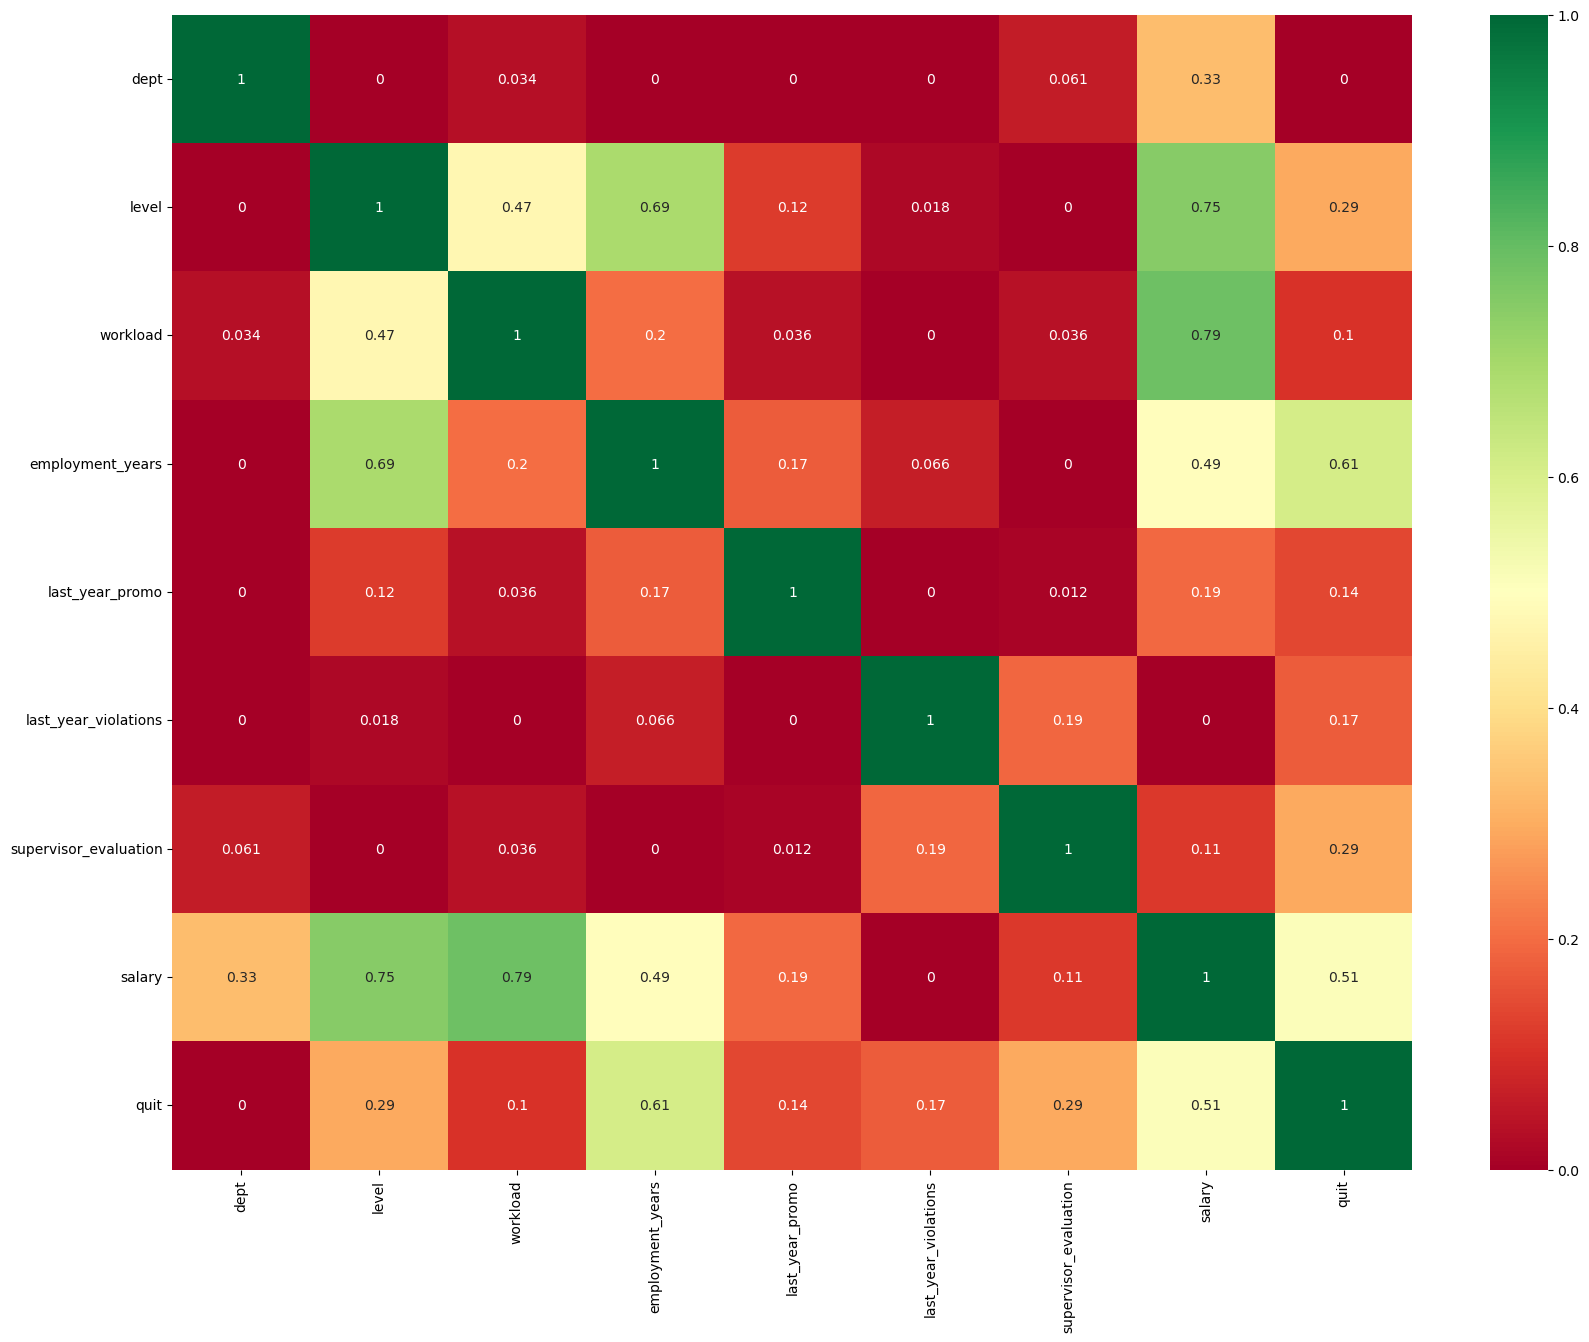

In [94]:
corr_matrix_test_two = test_class.drop('id', axis = 1).phik_matrix(interval_cols = column_num_train) 
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix_test_two, annot=True, cmap='RdYlGn') 
plt.show()

 </font><b>Промежуточные выводы исследовательского анализа: </b></font><br>
 
 Больше всего в датафрейме представлены в основном sales с средней нагрузкой на уровне junior. Что интересно, чаще всего встречающаяся оценка работы - 4.
 

#### Исследовательский анализ датафрейма test_target_quit_two

In [95]:
test_target_quit_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


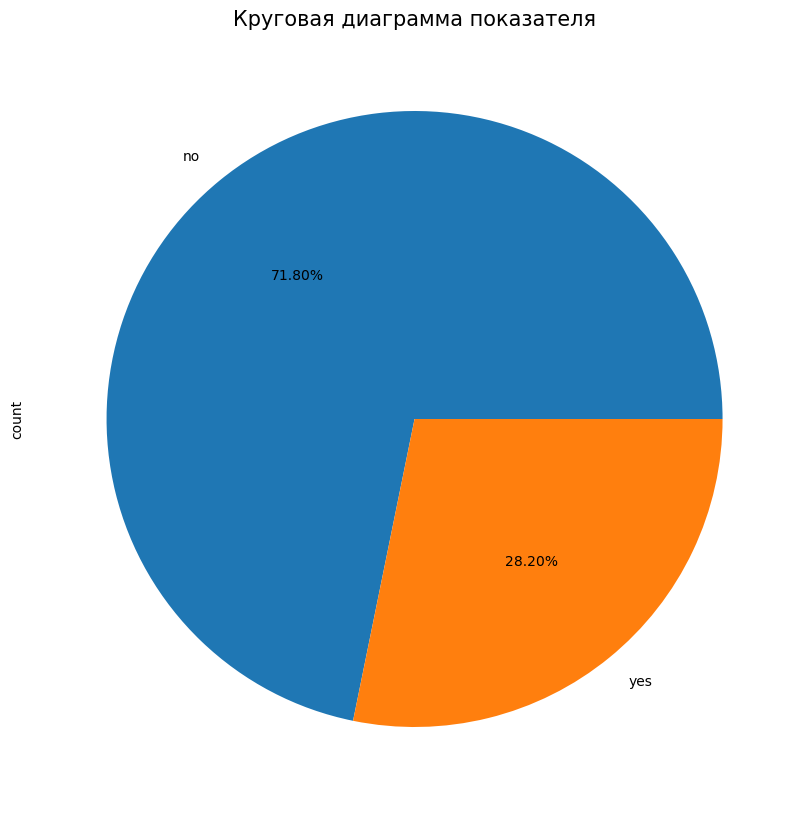

In [96]:
analisys_cat_pie(test_target_quit_two['quit'])

 </font><b>Промежуточные выводы исследовательского анализа: </b></font><br>
 
 Больше всего в датафрейме уволившихся сотрудников

#### Портрет уволившегося сотрудника

##### Портрет на основе тренировочных данных

In [97]:
px.scatter(train_quit_two, x = 'level', y = 'salary', color = 'quit',
           title = 'Диаграмма рассеяния зарплаты у сотрудников',
           labels = dict(salary = 'Зарплата', level = 'Уровень',  quit = 'Уволился'))

In [98]:
px.scatter(train_quit_two, x = 'workload', y = 'salary', color = 'quit',
           title = 'Диаграмма рассеяния нагрузки сотрудников',
           labels = dict(salary = 'Зарплата', workload = 'Нагрузка',  quit = 'Уволился'))

In [99]:
model = random_search.best_estimator_

In [100]:
train_quit_two['job_satisfaction_rate'] = model.predict(train_quit_two)

In [101]:
train_quit_two.head(10)

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   
5  699916       sales  junior      low                 1              no   
6  417070  technology  middle   medium                 8              no   
7  165489       sales  middle      low                 4              no   
8  996399   marketing  middle      low                 7              no   
9  613206  technology  middle   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  \
0                   no                      4   54000   no   
1                   no                      4   27600   no   
2                   no                      1   37200   no   
3                  yes                      3   24000  yes   
4                   no                      5   25200   no   
5                  yes                      3   18000  yes   
6                   no                      2   44400   no   
7                   no                      5   19200   no   
8                   no                      4   25200   no   
9                   no                      3   45600  yes   

   job_satisfaction_rate  
0               0.631087  
1               0.843158  
2               0.340000  
3               0.367778  
4               0.797857  
5               0.180000  
6               0.365000  
7               0.470000  
8               0.800588  
9               0.338824

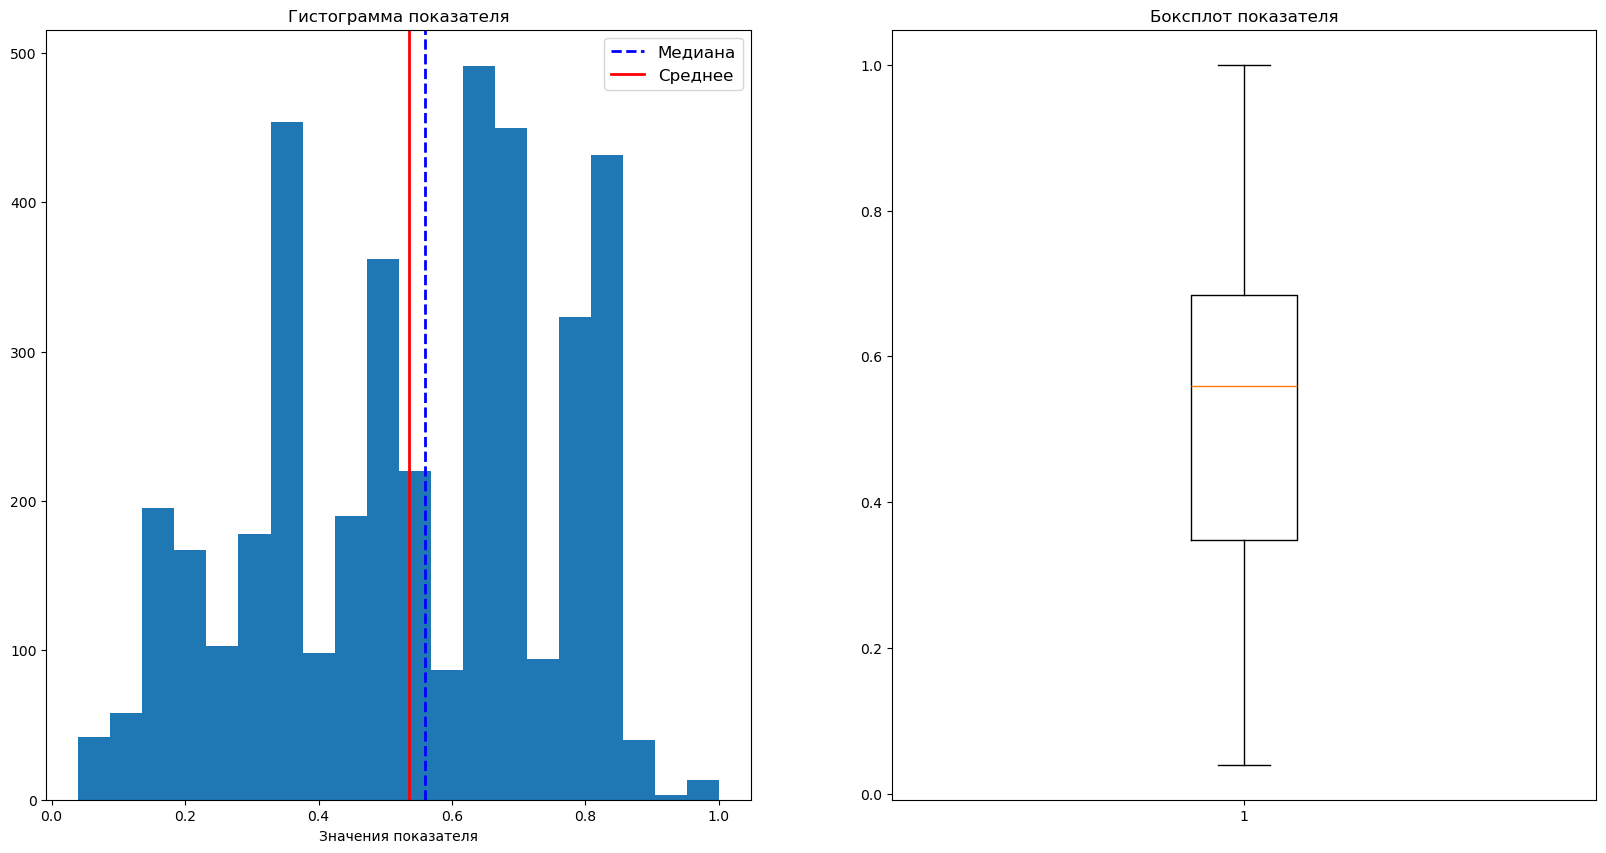

Показатели описательной статистики
count    4000.000000
mean        0.536281
std         0.217592
min         0.040000
25%         0.348875
50%         0.560000
75%         0.684444
max         1.000000
Name: job_satisfaction_rate, dtype: float64


In [102]:
analisys_num(train_quit_two['job_satisfaction_rate'])

In [103]:
quit_worker = train_quit_two.query('quit == "yes"')

In [104]:
worker_now =  train_quit_two.query('quit == "no"')

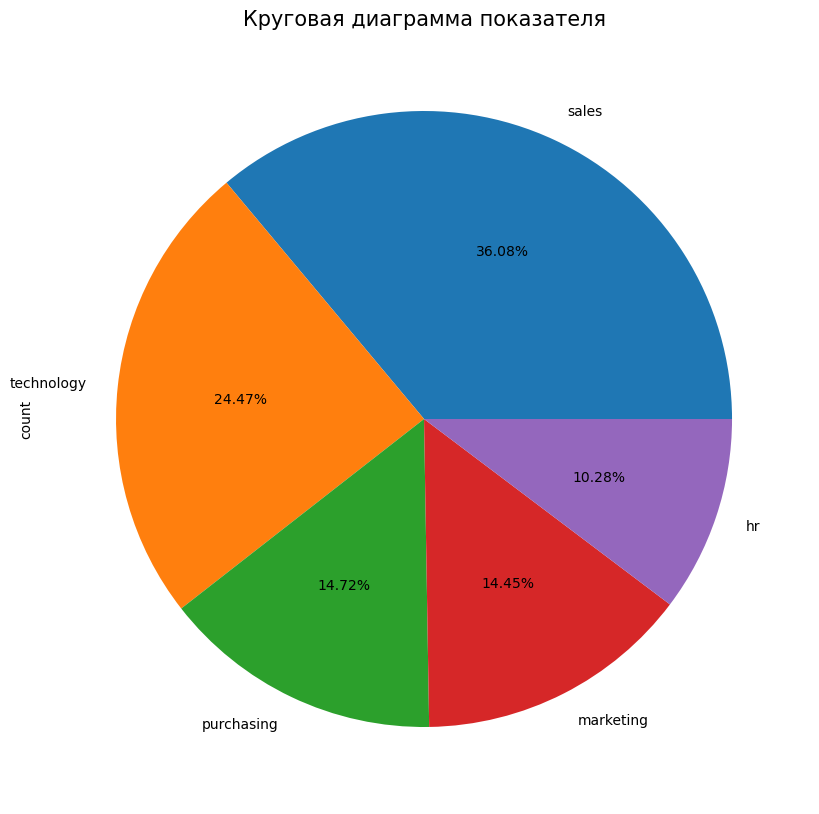

In [105]:
analisys_cat_pie(quit_worker['dept'])

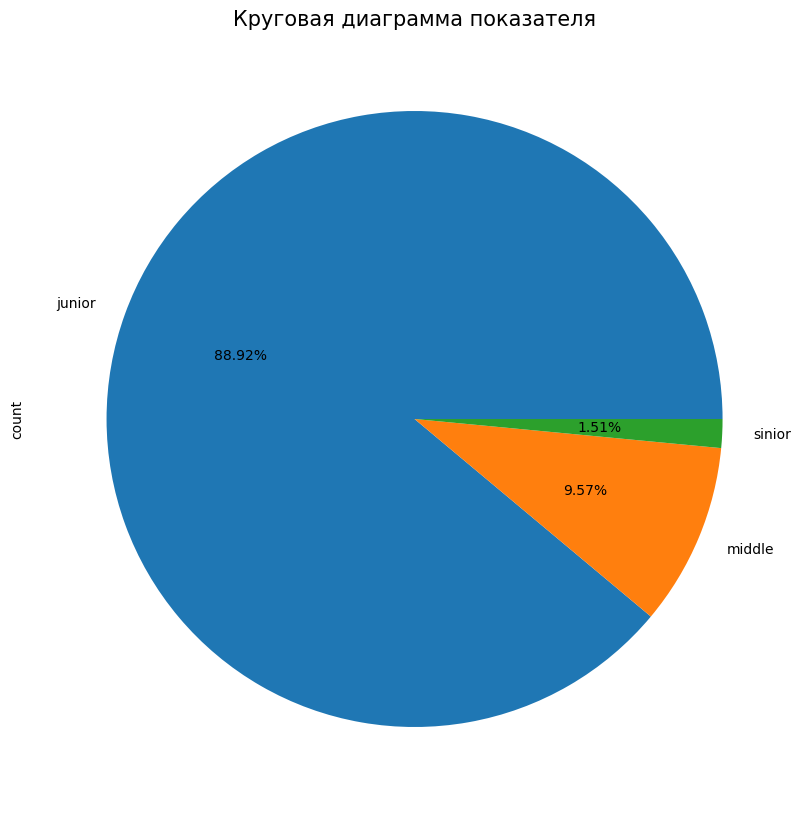

In [106]:
analisys_cat_pie(quit_worker['level'])

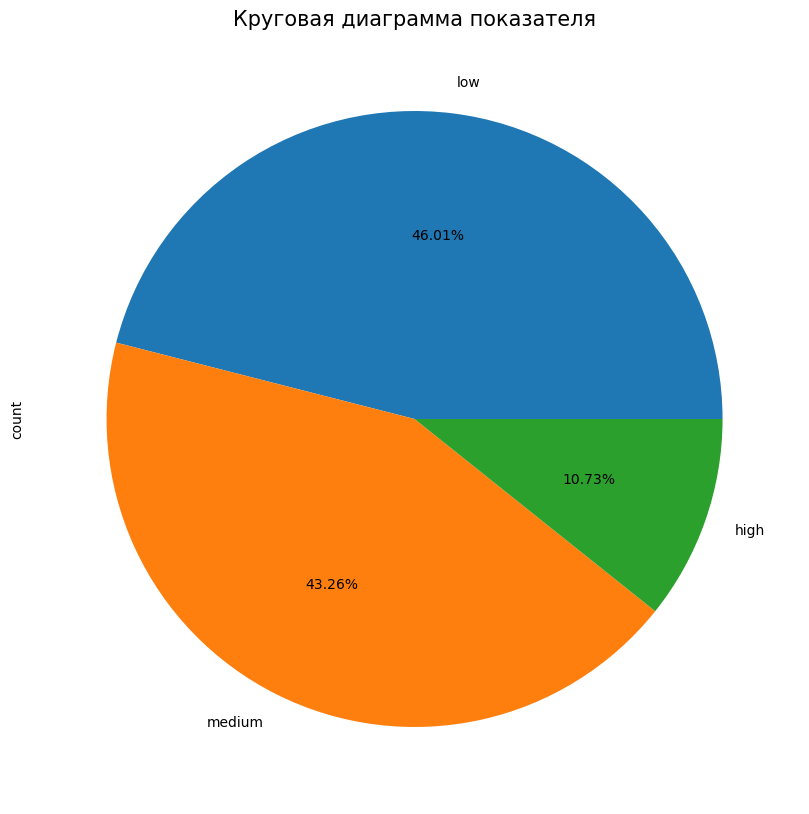

In [107]:
analisys_cat_pie(quit_worker['workload'])

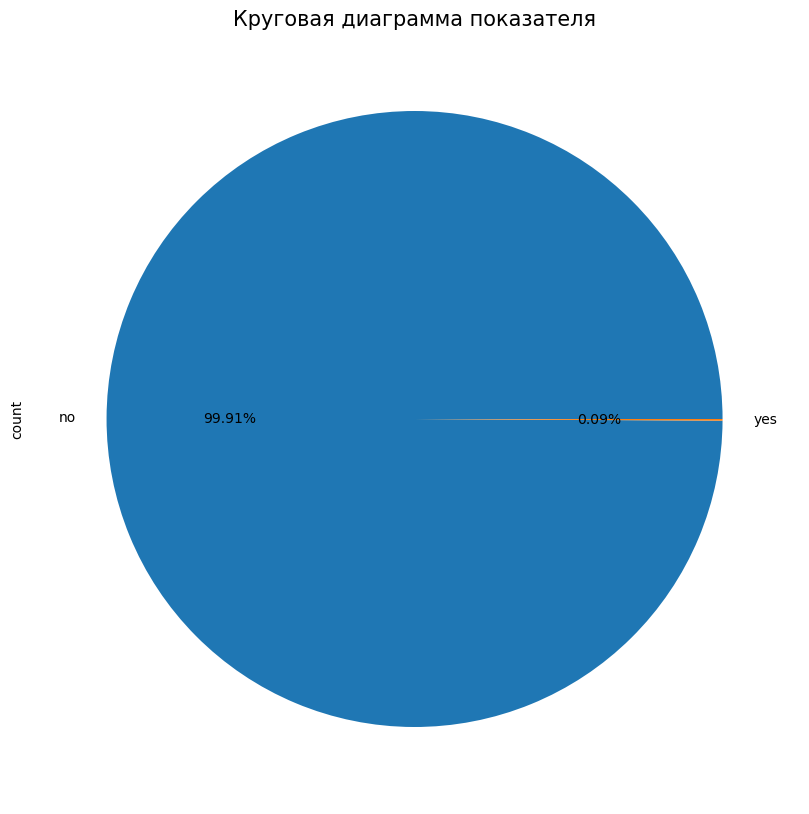

In [108]:
analisys_cat_pie(quit_worker['last_year_promo'])

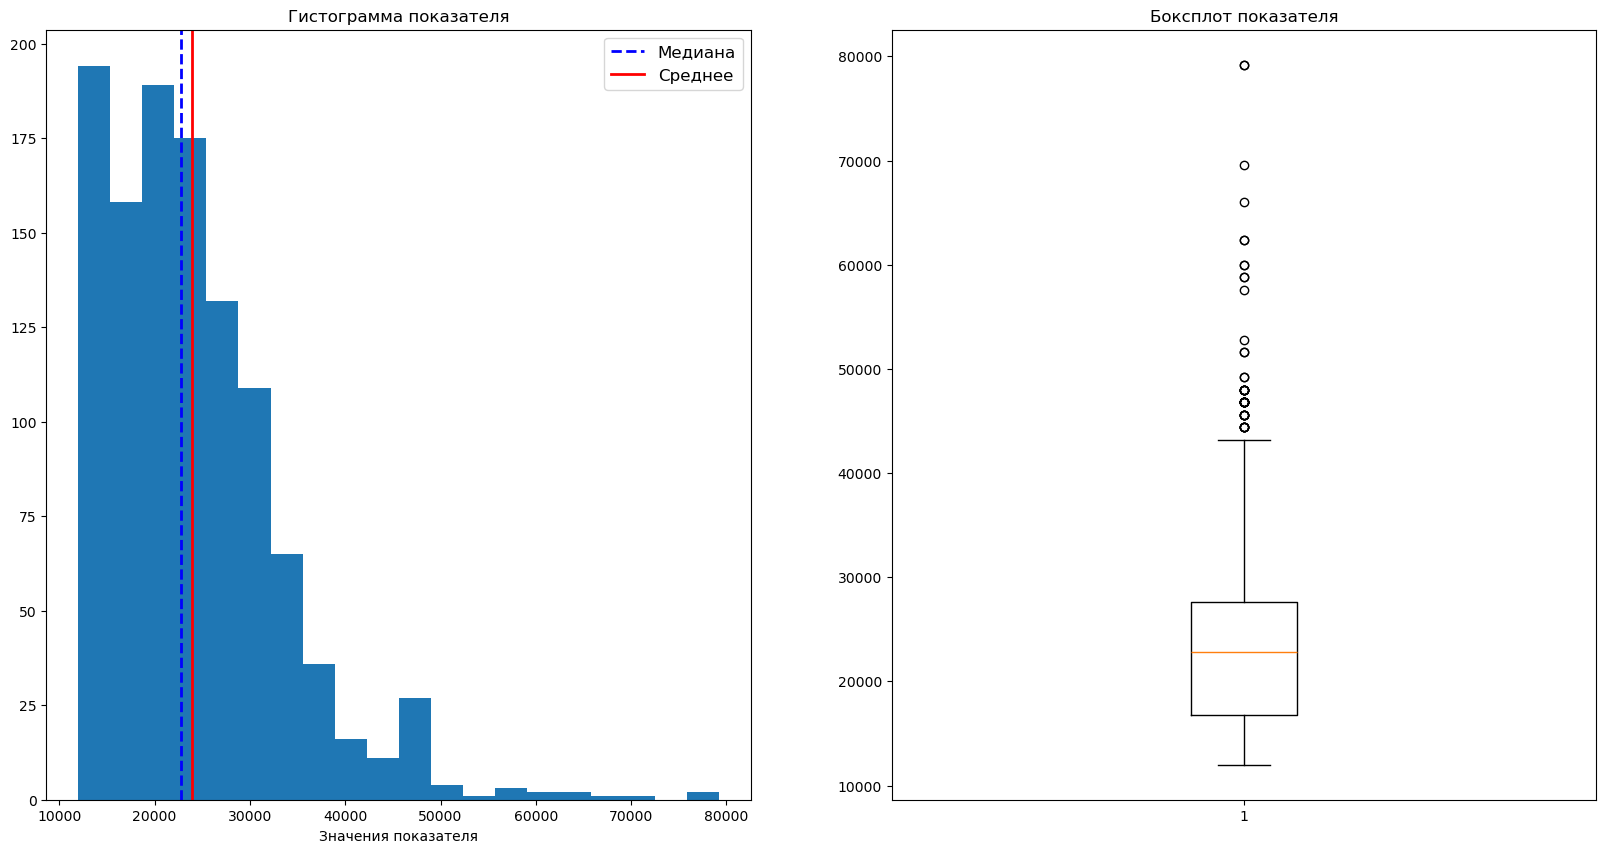

Показатели описательной статистики
count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64


In [109]:
analisys_num(quit_worker['salary'])

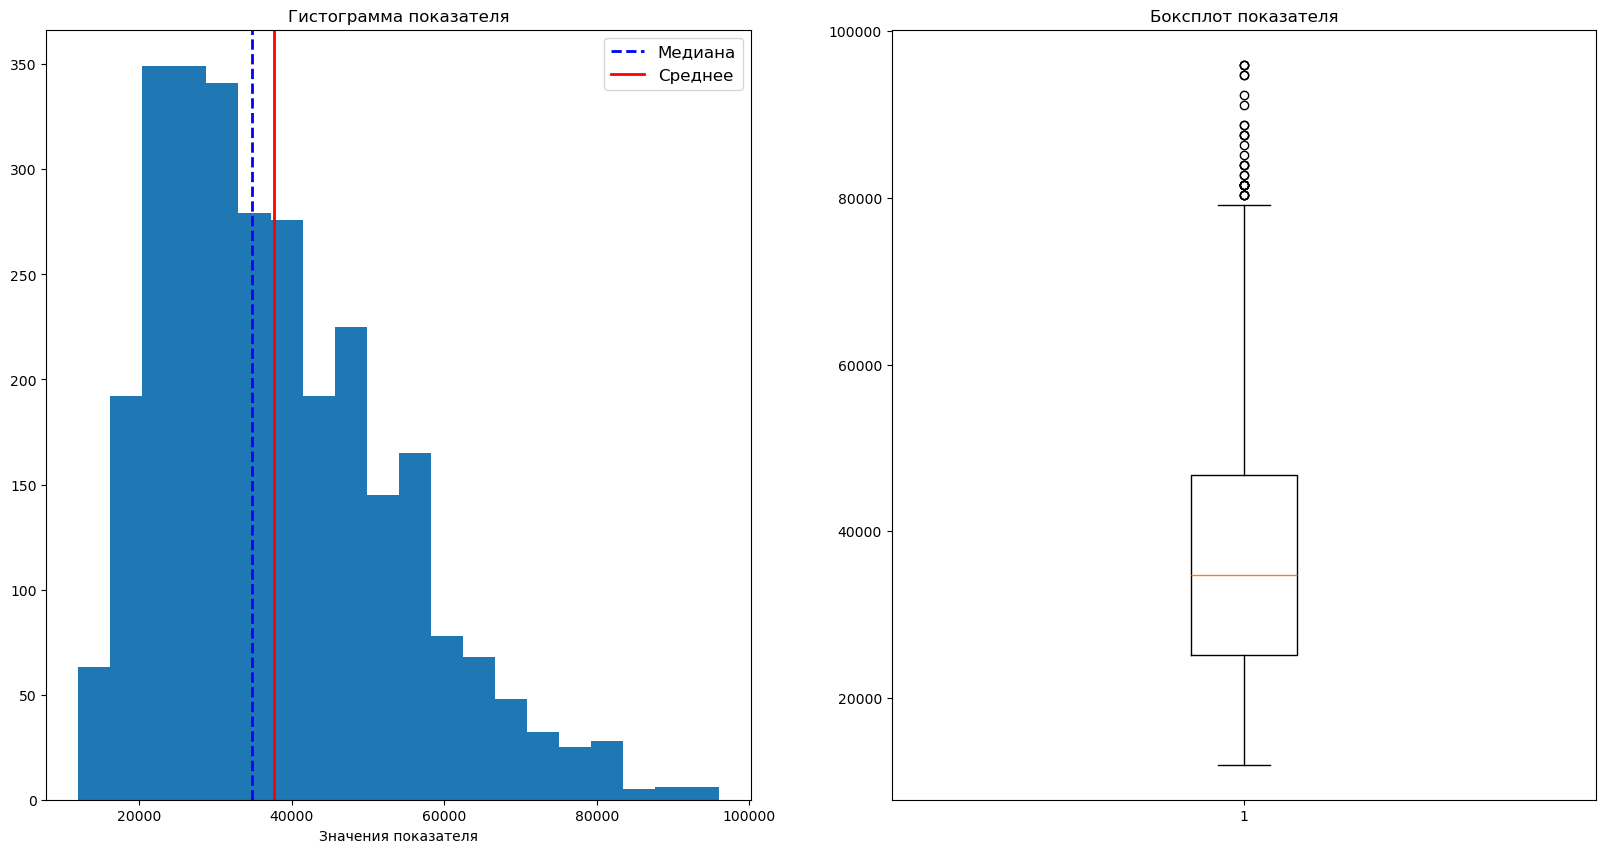

Показатели описательной статистики
count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64


In [110]:
analisys_num(worker_now['salary'])

 </font><b>Портрет уволившегося сотрудника: </b></font><br>
 
Для составления портрета уволившегося сотрудника были отобраны признаки, которые могут повлият на решение сотрудника сменить работу:

1. Должность

Ели рассмотреть распределение работников в комапнии, то можно увидеть что есть подразделения, в которых задействовано больше сотрудников, чем в других. От долности может зависеть нагрузка и заработная плата. Например, человек может захотеть сменить работу, тк в данной компании должностные обязанности отличаются от оффера в менее выгодную сторону.

2. Уровень

Так же как и должность различные уровни могут содержать различные должностные обязанности и различную нагрузку. В различных компаниях уровень может зависеть от различных факторов, то есть в одной компании чтобы стать middle необходимо иметь 1 год опыта, а в другой 3 года опыта. В связи с этим сотрудник может быть заинтересован сменить место работы, т к другая компания может предложить более стремительный карьерный трек.

3. Нагрузка

Рабочая нагрузка является одной из важных составляющих в решении сотрудника сменить место работы. Если на данном месте работы сотрудник имеет высокую нагрузку, которую ему сложно выносить, то это может стать одним из решающих факторов для уволнения.

4. Повышение в течение года

Возможность развития, как специалиста, является важной частью карьеры. Если сотрудник понимает, что на данном месте работы нет карьерного роста или он медленный, то это может быть фактором для смены работы.

5. Заработная плата

Заработная плата является самым главнфм фактором выбора работы. Так как работник продает свое время работодателю, то он будет ожидать определенную оплату. Конкуренты могут привлекать работников в первую очередь заработной платой.

6. Оценка удовлетворенности

Посредством оценки удовлетворенности можно вовремя обратить внимание на сотрудника и провести анализ его места работы и выявить, что его может не устраивать

Оценкка руководителя может не влиять на решение работника. Например, руководитель может ставить высокую оценку работе, но сотрудника не устраивает нагрузка и оплата за такую нагрузку. 

Нарушение трудового договора сотрудником может привести к расторжению с стороны организации, а не увольнения сотрудника по его желанию. 



 </font><b>Из исследования можно сделать вывод: </b></font><br>
 
 Уволняются сотрудники из департамента sales junior с средней нагрузкой, которых не повышали в течение года. Зарплата уволившегося сотрудника находится на уровне 23000 и урвоень удовлетворенности 0.2 - 0.3.

##### Портрет на основе тестовых данных

In [111]:
test_class.head(10)

id        dept   level workload  employment_years last_year_promo  \
0  485046   marketing  junior   medium                 2              no   
1  686555          hr  junior   medium                 1              no   
2  467458       sales  middle      low                 5              no   
3  418655       sales  middle      low                 6              no   
4  789145          hr  middle   medium                 5              no   
5  429973  purchasing  middle   medium                 6              no   
6  850699  technology  junior   medium                 3              no   
7  500791       sales  middle     high                 9              no   
8  767867   marketing  middle     high                 3              no   
9  937235       sales  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      5   28800   no  
1                   no                      4   30000   no  
2                   no                      4   19200   no  
3                   no                      4   19200   no  
4                   no                      5   40800   no  
5                   no                      3   42000  yes  
6                   no                      3   26400  yes  
7                   no                      4   49200   no  
8                  yes                      4   62400   no  
9                  yes                      3   26400  yes

In [112]:
test_class['job_satisfaction_rate'] = model.predict(test)

In [113]:
test_class.head(10)

id        dept   level workload  employment_years last_year_promo  \
0  485046   marketing  junior   medium                 2              no   
1  686555          hr  junior   medium                 1              no   
2  467458       sales  middle      low                 5              no   
3  418655       sales  middle      low                 6              no   
4  789145          hr  middle   medium                 5              no   
5  429973  purchasing  middle   medium                 6              no   
6  850699  technology  junior   medium                 3              no   
7  500791       sales  middle     high                 9              no   
8  767867   marketing  middle     high                 3              no   
9  937235       sales  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary quit  \
0                   no                      5   28800   no   
1                   no                      4   30000   no   
2                   no                      4   19200   no   
3                   no                      4   19200   no   
4                   no                      5   40800   no   
5                   no                      3   42000  yes   
6                   no                      3   26400  yes   
7                   no                      4   49200   no   
8                  yes                      4   62400   no   
9                  yes                      3   26400  yes   

   job_satisfaction_rate  
0               0.830870  
1               0.830870  
2               0.790426  
3               0.816098  
4               0.752432  
5               0.698889  
6               0.430577  
7               0.797857  
8               0.684444  
9               0.291667

#### Портрет уволившего сотрудника. Вывод

Из графиков видно, что увольняются в основном работники с удовлетворенностью до 0.8 уровня junior при занятости sales и различной загрузкой и средней зарплатой 23000. 

In [114]:
for_hist = test_class

In [115]:
for_hist['job_satisfaction_rate'] = test['job_satisfaction_rate']

In [116]:
for_hist

id        dept   level workload  employment_years last_year_promo  \
0     485046   marketing  junior   medium                 2              no   
1     686555          hr  junior   medium                 1              no   
2     467458       sales  middle      low                 5              no   
3     418655       sales  middle      low                 6              no   
4     789145          hr  middle   medium                 5              no   
...      ...         ...     ...      ...               ...             ...   
1995  393147   marketing  junior      low                 3              no   
1996  109582  technology  middle      low                 3              no   
1997  305653  technology  junior      low                 1              no   
1998  160233  technology  middle      low                 8              no   
1999  771859  purchasing  middle   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary quit  \
0                      no                      5   28800   no   
1                      no                      4   30000   no   
2                      no                      4   19200   no   
3                      no                      4   19200   no   
4                      no                      5   40800   no   
...                   ...                    ...     ...  ...   
1995                   no                      3   20400  yes   
1996                   no                      2   21600  yes   
1997                   no                      3   14400  yes   
1998                   no                      1   32400   no   
1999                   no                      4   38400   no   

      job_satisfaction_rate  
0                      0.80  
1                      0.84  
2                      0.79  
3                      0.75  
4                      0.69  
...                     ...  
1995                   0.79  
1996                   0.76  
1997                   0.48  
1998                   0.57  
1999                   0.35  

[2000 rows x 11 columns]

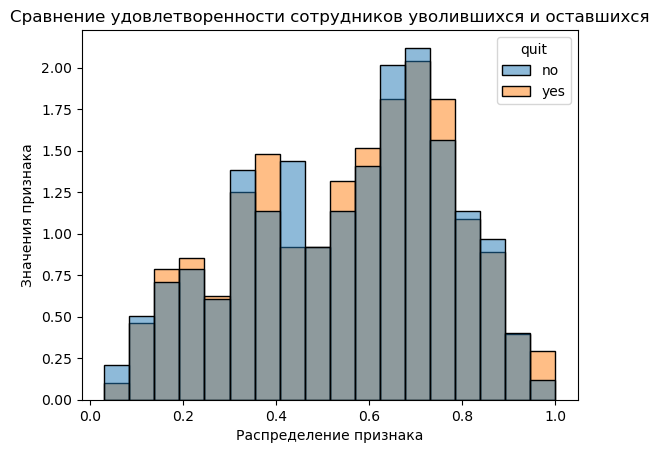

In [117]:
sns.histplot(data = for_hist, x = 'job_satisfaction_rate', hue = 'quit', stat='density', common_norm=False)
plt.title('Сравнение удовлетворенности сотрудников уволившихся и оставшихся')
plt.xlabel('Распределение признака')
plt.ylabel('Значения признака')
plt.show()

Уволившиеся сотрудники в основном оценивают место работы около 0.2-0.3.

### Подготовка данных

Ранее мы объединили данные и добавили дополнительные данные. На данном этапе вынесем в отдельные датафреймы входные и целевые признаки

In [118]:
X_train_class = train_quit_two.drop(['id', 'quit'], axis = 1)
y_train_class = train_quit_two['quit']

In [119]:
X_test_class = test_class.drop(['id','quit'], axis = 1)
y_test_class = test_class['quit']

In [120]:
y_test_class.unique()

array(['no', 'yes'], dtype=object)

In [121]:
label_encoder = LabelEncoder()
y_train_class = label_encoder.fit_transform(y_train_class)
y_test_class = label_encoder.transform(y_test_class)

In [122]:
label_encoder.classes_

array(['no', 'yes'], dtype=object)

### Обучение модели

In [123]:
X_test_class.head(10)

dept   level workload  employment_years last_year_promo  \
0   marketing  junior   medium                 2              no   
1          hr  junior   medium                 1              no   
2       sales  middle      low                 5              no   
3       sales  middle      low                 6              no   
4          hr  middle   medium                 5              no   
5  purchasing  middle   medium                 6              no   
6  technology  junior   medium                 3              no   
7       sales  middle     high                 9              no   
8   marketing  middle     high                 3              no   
9       sales  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      5   28800                   0.80  
1                   no                      4   30000                   0.84  
2                   no                      4   19200                   0.79  
3                   no                      4   19200                   0.75  
4                   no                      5   40800                   0.69  
5                   no                      3   42000                   0.68  
6                   no                      3   26400                   0.49  
7                   no                      4   49200                   0.73  
8                  yes                      4   62400                   0.66  
9                  yes                      3   26400                   0.26

In [124]:
ohe_column_two = ['dept', 'last_year_promo', 'last_year_violations']
ord_column_two = ['level', 'workload']
num_column_two = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [125]:
ohe_pipe_two = Pipeline(
    [
        (
            'simpleImputer_ohe_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'simpleImputer_ohe_space', SimpleImputer(missing_values=" ", strategy='constant', fill_value = np.nan)
        ),
        (
            'simpleImputer_ohe_nan_two', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [126]:
ord_pipe_two = Pipeline(
    [
        (
            'simpleImputer_ohe_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'simpleImputer_ohe_space', SimpleImputer(missing_values=" ", strategy='constant', fill_value = np.nan)
        ),
        (
            'simpleImputer_ohe_nan_two', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['low', 'medium', 'high']], 
            handle_unknown='use_encoded_value', unknown_value=np.nan)
        )
    ]
)

In [127]:
data_preprocessor_two = ColumnTransformer(
    [('ohe', ohe_pipe_two, ohe_column_two),
     ('ord', ord_pipe_two, ord_column_two),
     ('num', StandardScaler(), num_column_two)], 
    remainder='passthrough') 

In [128]:
pipe_final_two = Pipeline([
    ('preprocessor', data_preprocessor_two),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

In [129]:
param_grid_two = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    {
        'models': [RandomForestClassifier()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }   
]

In [130]:
randomized_search_two = RandomizedSearchCV(
    pipe_final_two, 
    param_grid_two, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter = 100,
    n_jobs=-1)

randomized_search_two.fit(X_train_class, y_train_class) 

y_test_two = randomized_search_two.predict_proba(X_test_class)

print('Лучшая модель и её параметры:\n\n', randomized_search_two.best_estimator_)
print('Параметры лучшей модели:\n',randomized_search_two.best_params_)
print(f'\n\n Метрика ROC-AUC на кросс-валидационной выборке:', round(randomized_search_two.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_space',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 missing_values=' ',
                                                                                 strategy='constant')),
                                                                  ('simpleImputer_ohe_nan_two',
                                                                   SimpleImputer(strategy='most_frequent')),
                

In [131]:
print(f'\n\n Метрика ROC-AUC на тестовой выборке:', round(roc_auc_score(y_test_class, y_test_two[:, 1]),3))



 Метрика ROC-AUC на тестовой выборке: 0.71


 </font><b>Выводы: </b></font><br>
 
 Лучшей моделью для данной цели является DecisionTreeClassifier с параметрами max_features 6 и max_depth 5. При препроцессинге неоюходимо использовать MinMaxScaler().

## Общие выводы

1. Были проведены предподготовка данных и  исследовательский анализ данных.

2. Обучены модели для предсказания уровня удовлетворенности работников и получена лучшая (DecisionTreeRegressor)

3. Обучены модели для предсказания уволнения работников и получена лучша (DecisionTreeClassifier)

4. Получен портрет уволившегося сотрудника.

Увольняются в основном работники с удовлетворенностью 0.2 - 0.3 уровня junior при занятости sales и различной загрузкой и зарплатой в среднем 23000.

 </font><b>Рекомендации: </b></font><br>
 
Группой риска являются sales на уровне junior. Так же большая часть уволившихся сотрудников не получали повышение в течение года. Необходимо рассмотреть подходы повышающие замотивированность сотрудников, так пересмотреть систему повышения  сотрудников. 

In [132]:
print('Конец проекта, код не упал')

Конец проекта, код не упал
